## updated of figures notebook coded from plot functions in the library

In [1]:
%matplotlib inline

from pathlib import Path
from types import SimpleNamespace
from joblib import delayed, Parallel
import time
import traceback

import numpy as np
import pandas as pd
import scipy.stats as stats
pd.set_option('display.max_rows', 50)

import matplotlib as mpl

import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.path as mpath
import seaborn as sns
sns.set(style='whitegrid', palette='muted')
from matplotlib_venn import venn2, venn3

import TreeMazeAnalyses2.Utils.robust_stats as rs
import TreeMazeAnalyses2.Analyses.experiment_info as ei
import TreeMazeAnalyses2.Analyses.spatial_functions as sf
import TreeMazeAnalyses2.Analyses.open_field_functions as of
import TreeMazeAnalyses2.Analyses.plot_functions as pf
#import TreeMazeAnalyses2.Analyses.cluster_match_functions as cmf

from importlib import reload

import ipywidgets as widgets
from ipywidgets import interact, fixed, interact_manual
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
ei = reload(ei)
info = ei.SummaryInfo()
#info.update_paths()
#info.overwrite_subj_obj()

In [3]:
overwrite=False
metric_scores, model_scores = info.get_of_results(model_analyses='new', overwrite=overwrite)
unit_table = info.get_unit_table()

In [31]:
model_scores.columns

Index(['unit_id', 'subject', 'session', 'session_unit_id', 'unit_type',
       'session_pct_cov', 'session_valid', 'tt', 'tt_cl', 'model', 'split',
       'metric', 'value', 'cl_name'],
      dtype='object')

In [34]:
model_scores[model_scores['metric']=='agg_sdp_coef']

unit_id subject       session  session_unit_id unit_type  \
0            0      Li  Li_OF_052818                0      cell   
1            0      Li  Li_OF_052818                0      cell   
10           1      Li  Li_OF_052818                1      cell   
11           1      Li  Li_OF_052818                1      cell   
20           2      Li  Li_OF_052818                2      cell   
...        ...     ...           ...              ...       ...   
84285     2219      Mi  Mi_OF_021820                0      cell   
84294     2219      Mi  Mi_OF_021820                0      cell   
84295     2219      Mi  Mi_OF_021820                0      cell   
84304     2219      Mi  Mi_OF_021820                0      cell   
84305     2219      Mi  Mi_OF_021820                0      cell   

       session_pct_cov  session_valid  tt  tt_cl  model  split        metric  \
0                 0.96           True   7      8  speed   test  agg_sdp_coef   
1                 0.96           True   7      8  speed  train  agg_sdp_coef   
10                0.96           True   8      4  speed   test  agg_sdp_coef   
11                0.96           True   8      4  speed  train  agg_sdp_coef   
20                0.96           True   8     18  speed   test  agg_sdp_coef   
...                ...            ...  ..    ...    ...    ...           ...   
84285             0.92           True  14     11  speed  train  agg_sdp_coef   
84294             0.92           True  14     11     hd   test  agg_sdp_coef   
84295             0.92           True  14     11     hd  train  agg_sdp_coef   
84304             0.92           True  14     11    pos   test  agg_sdp_coef   
84305             0.92           True  14     11    pos  train  agg_sdp_coef   

          value                         cl_name  
0      0.613844     Li_OF_052818-tt7_d17.25_cl8  
1      0.613844     Li_OF_052818-tt7_d17.25_cl8  
10     0.916861     Li_OF_052818-tt8_d16.25_cl4  
11     0.916861     Li_OF_052818-tt8_d16.25_cl4  
20     0.602842    Li_OF_052818-tt8_d16.25_cl18  
...         ...                             ...  
84285  0.764560  Mi_OF_021820-tt14_d16.375_cl11  
84294  0.882052  Mi_OF_021820-tt14_d16.375_cl11  
84295  0.882052  Mi_OF_021820-tt14_d16.375_cl11  
84304  3.218610  Mi_OF_021820-tt14_d16.375_cl11  
84305  3.218610  Mi_OF_021820-tt14_d16.375_cl11  

[13314 rows x 14 columns]

In [4]:
analyses=['speed','hd','border','grid', 'stability']
@interact(analysis_type=analyses, unit_type=['cell', 'mua', None], thr=widgets.FloatSlider(min=-1, max=1, step=0.02))
def metric_filter_units(analysis_type, thr, unit_type=None):
    if unit_type is None:
        sub_table = metric_scores.loc[ (metric_scores.analysis_type==analysis_type) 
                                      & (metric_scores.score>=thr) 
                                      & (metric_scores.session_valid)]
    else:
        sub_table = metric_scores.loc[ (metric_scores.unit_type==unit_type) 
                                      & (metric_scores.analysis_type==analysis_type) 
                                      & (metric_scores.score>=thr)
                                      & (metric_scores.session_valid)]
    return sub_table.sort_values(by=['score'], ascending=False)

interactive(children=(Dropdown(description='analysis_type', options=('speed', 'hd', 'border', 'grid', 'stabili…

In [6]:
pf = reload(pf)

analysis_type = 'hd'
thr = 0.2
sub_metric_table = metric_filter_units(analysis_type=analysis_type, thr=thr)

pf = reload(pf)
f = pf.OpenFieldFigures()

@interact(idx=sub_metric_table.index)
def plot_OF_unit(idx):

    uuid = metric_scores.loc[idx, 'unit_id']
    cl_name = metric_scores.loc[idx, 'cl_name']
    unit_table_idx = unit_table[unit_table.unique_cl_name==cl_name].index[0]
    print(f"UUID = {uuid}")
    print(f"cl_name = {cl_name}")
    print(f"unit_table_idx = {unit_table_idx}")
    
    f.plot_of_tunning(cell_id=unit_table_idx, score_panel='metric')
    return metric_scores[metric_scores.cl_name==cl_name]

interactive(children=(Dropdown(description='idx', options=(1468, 1790, 10123, 2448, 1471, 10255, 4953, 1472, 1…

In [7]:
models=['speed','hd','border','grid', 'pos', 'agg_sdp']
metrics = ['r2', 'map_r','agg_sdp_coef']
splits = ['train', 'test']
@interact(model_type=models, metric=metrics, split=splits, unit_type=['cell', 'mua', None], thr=widgets.FloatSlider(min=-1, max=1, step=0.02))
def model_filter_units(model_type, metric, split, thr, unit_type=None):
    if unit_type is None:
        sub_table = model_scores.loc[ (model_scores.model==model_type)
                                      & (model_scores.split == split) 
                                      & (model_scores.metric == metric)
                                      & (model_scores.value>=thr) 
                                      & (model_scores.session_valid)]
    else:
        sub_table = model_scores.loc[ (model_scores.unit_type==unit_type) 
                                      & (model_scores.model==model_type)
                                      & (model_scores.split == split) 
                                      & (model_scores.metric == metric)
                                      & (model_scores.value>=thr)
                                      & (model_scores.session_valid)]
    return sub_table.sort_values(by=['value'], ascending=False)

interactive(children=(Dropdown(description='model_type', options=('speed', 'hd', 'border', 'grid', 'pos', 'agg…

In [8]:
pf = reload(pf)

model_type = 'hd'
split = 'test'
metric='r2'
thr = 0.2
sub_table = model_filter_units(model_type=model_type, metric=metric, split=split, thr=thr, unit_type=None)

pf = reload(pf)
f = pf.OpenFieldFigures()

@interact(idx=sub_table.index)
def plot_OF_unit2(idx):

    uuid = model_scores.loc[idx, 'unit_id']
    cl_name = model_scores.loc[idx, 'cl_name']
    unit_table_idx = unit_table[unit_table.unique_cl_name==cl_name].index[0]
    print(f"UUID = {uuid}")
    print(f"cl_name = {cl_name}")
    print(f"unit_table_idx = {unit_table_idx}")
    
    f.plot_of_tunning(cell_id=unit_table_idx, model_metric=metric, model_split=split)
    return model_scores[ (model_scores.unit_id==uuid) & (model_scores.metric==metric)]

interactive(children=(Dropdown(description='idx', options=(11260, 11240, 12796, 24314, 12806, 12906, 13704, 20…

In [8]:
metric ='r2'
split = 'train'
vars_name_list = ['speed', 'hd', 'pos']
scores = f.get_unit_model_scores(463)
scores = scores[(scores.model.isin(vars_name_list)) & (scores.split == split) & (scores.metric == metric)]
scores

unit_id subject       session  session_unit_id unit_type  \
25529      295      Li  Li_OF_061318                6      cell   
25795      295      Li  Li_OF_061318                6      cell   
26503      295      Li  Li_OF_061318                6      cell   

       session_pct_cov  session_valid  tt  tt_cl  model  split metric  \
25529             0.96           True   8      5  speed  train     r2   
25795             0.96           True   8      5     hd  train     r2   
26503             0.96           True   8      5    pos  train     r2   

          value                     cl_name  
25529  0.005614  Li_OF_061318-tt8_d16.5_cl5  
25795  0.503167  Li_OF_061318-tt8_d16.5_cl5  
26503  0.178694  Li_OF_061318-tt8_d16.5_cl5

In [9]:
pf = reload(pf)
f = pf.OpenFieldFigures()

In [17]:
pf = reload(pf)
f = pf.OpenFieldFigures()
#units = f.unique_unit_ids
units = [648, 462, 1288, 465, 1064]

@interact()
def plot_OF_unit3(cell_id=units, save_flag=[False,True]):
    print(unit_table.loc[cell_id, ['session', 'session_cl_id']])
    f.plot_of_tunning(cell_id=cell_id, models='sdp', model_split='test', save_flag=save_flag, save_format='svg')


interactive(children=(Dropdown(description='cell_id', options=(648, 462, 1288, 465, 1064), value=648), Dropdow…

### example model output

In [25]:
pf = reload(pf)
f2 = pf.OpenFieldFigures()

In [26]:
units = [648, 462, 1288, 1064]
for u in units:
    f2.get_unit_encoder_models(u)

Getting Encoding Models
speed model completed. 6.43secs
hd model completed. 6.30secs
pos model completed. 14.13secs
aggregate sdp model completed. 5.64secs
Getting Encoding Models
speed model completed. 3.09secs
hd model completed. 2.92secs
pos model completed. 6.53secs
aggregate sdp model completed. 2.91secs
Getting Encoding Models
speed model completed. 4.34secs
hd model completed. 4.20secs
pos model completed. 8.79secs
aggregate sdp model completed. 3.79secs
Getting Encoding Models
speed model completed. 4.43secs
hd model completed. 4.20secs
pos model completed. 10.14secs
aggregate sdp model completed. 3.79secs


In [52]:
units = [648, 462, 1288, 1064]
for unit in units:
    f2.plot_model_resp_tw(cell_id=unit, save_flag=True, figsize=(1.6,2.25), save_format='svg')


KeyboardInterrupt



Error in callback <function flush_figures at 0x7fd9fcfd3280> (for post_execute):


KeyboardInterrupt: 

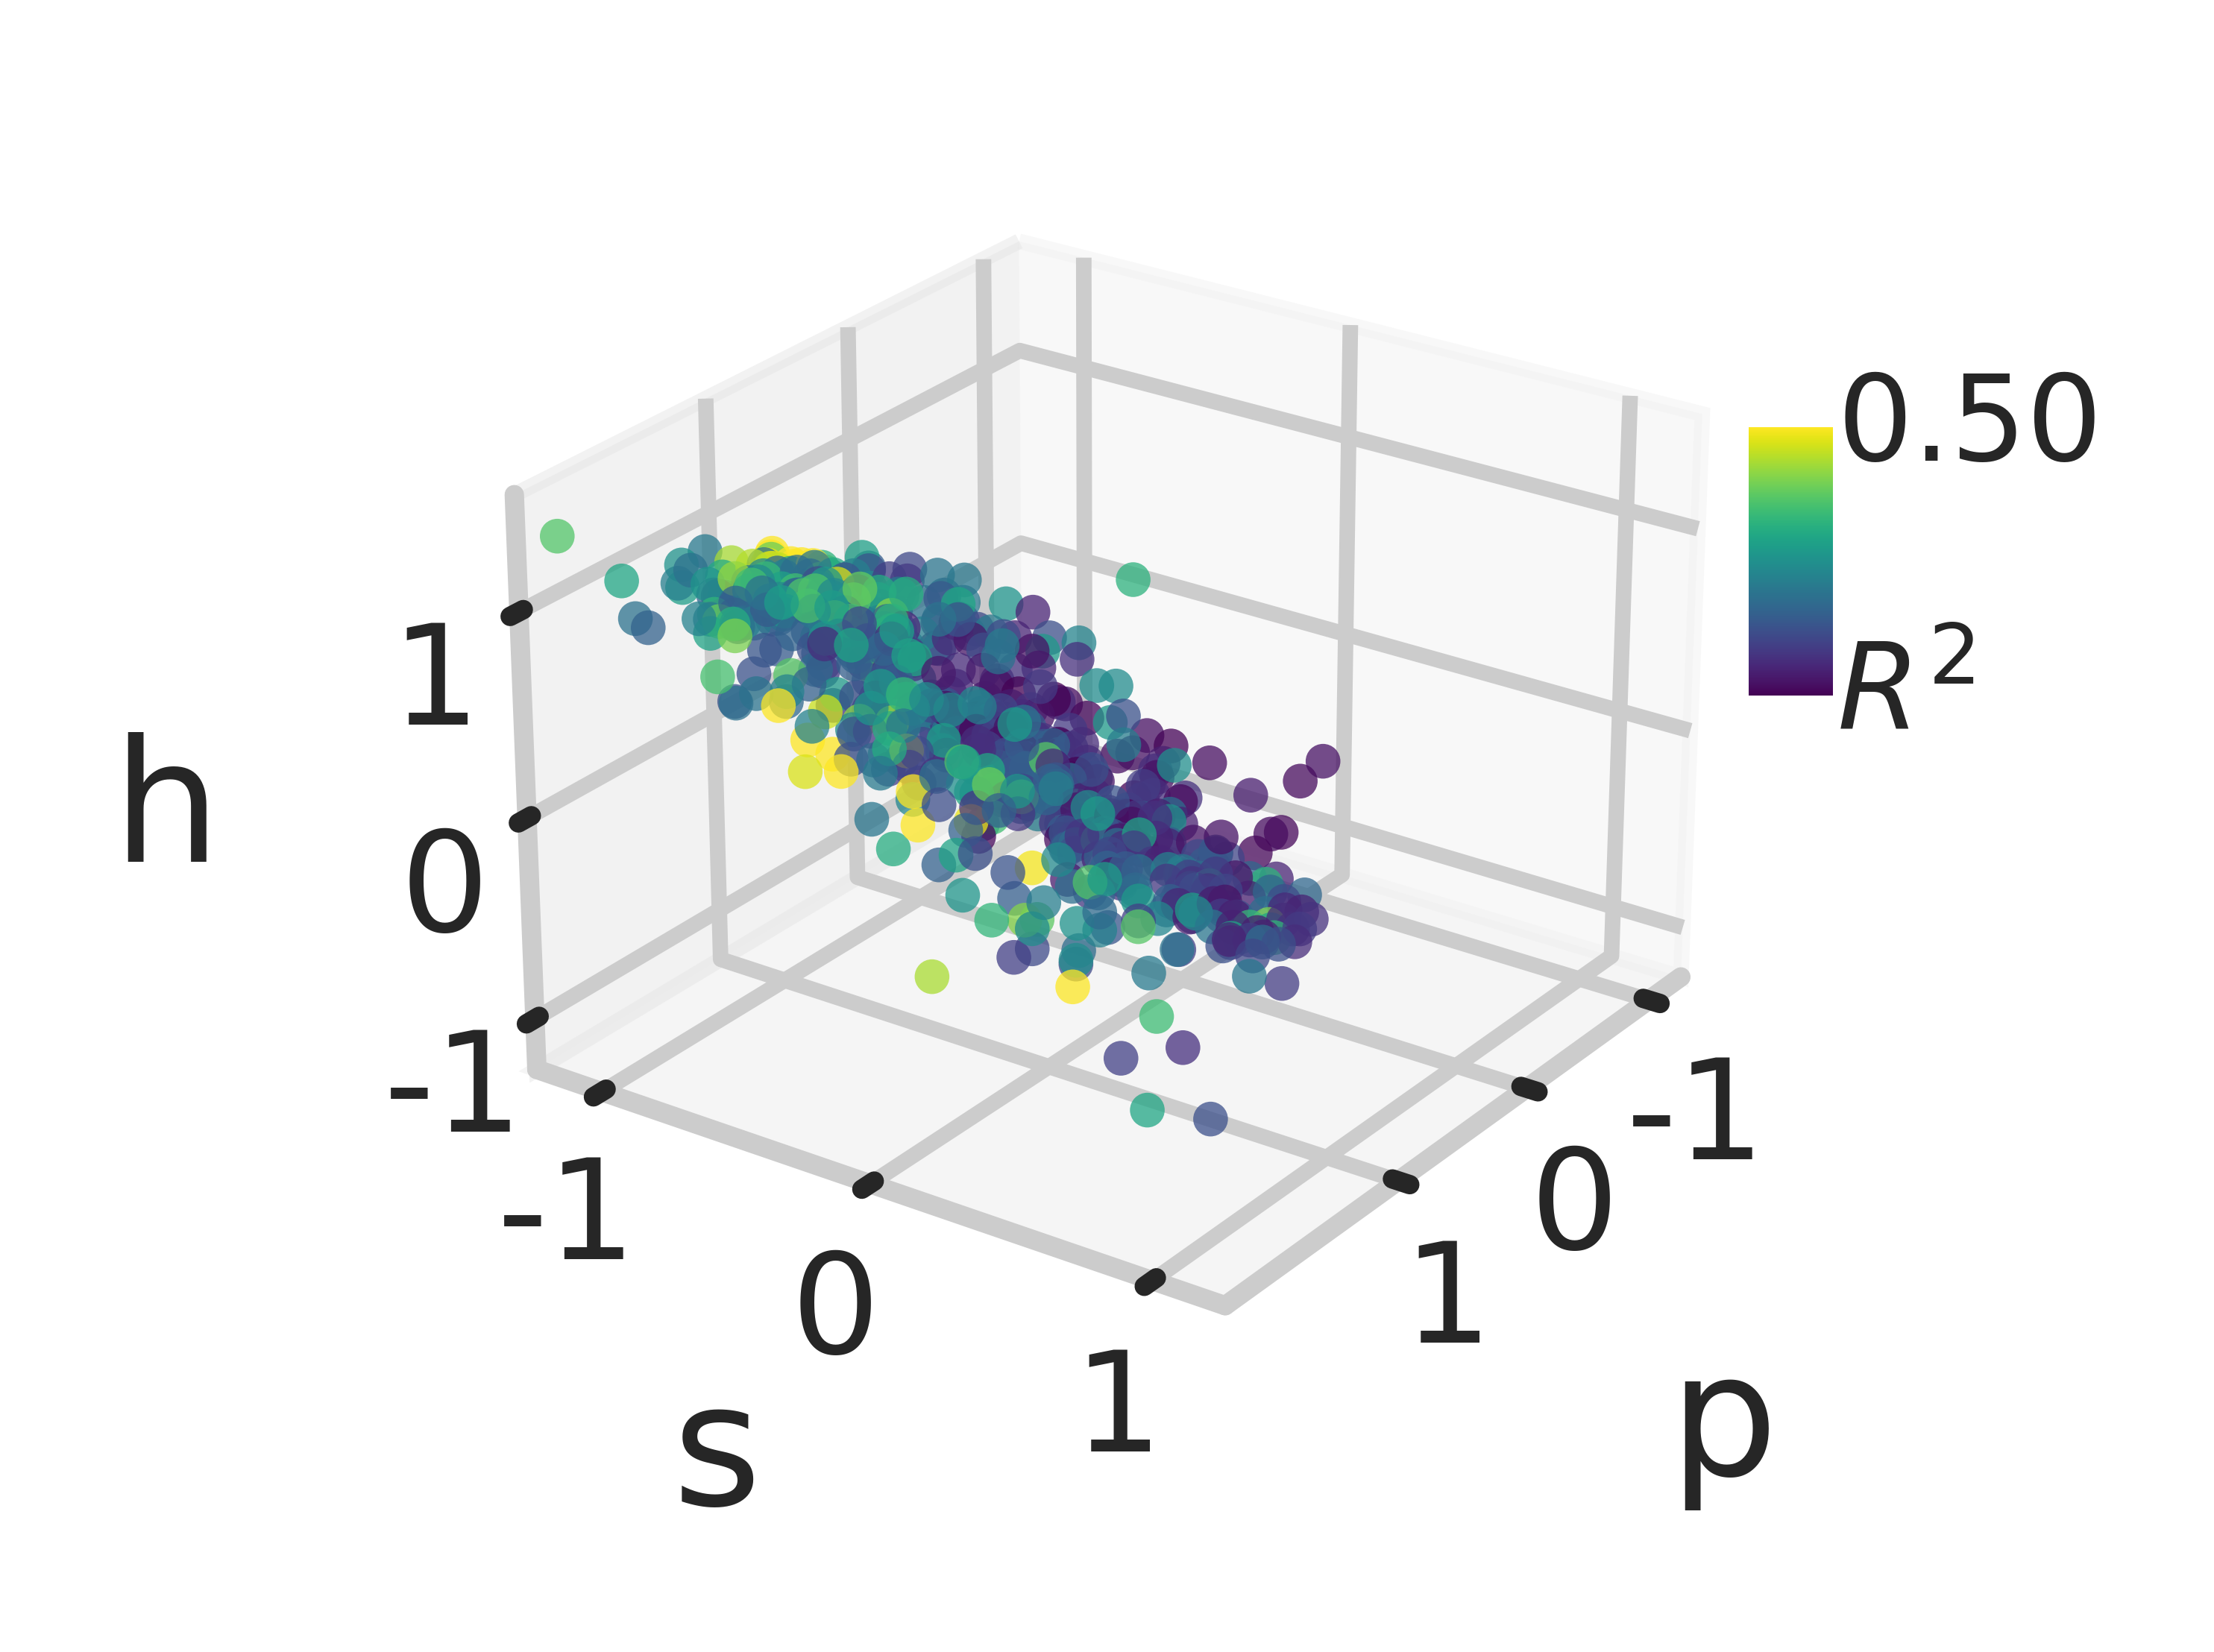

In [70]:
pf = reload(pf)
f3 = pf.OpenFieldFigures()
_=f3.plot_agg_model_coef(figsize=(1.5,1.6),save_flag=True)

(<Figure size 2700x2100 with 4 Axes>,
 array([<AxesSubplot:xlabel='s', ylabel='$R^2$'>, <AxesSubplot:xlabel='h'>,
        <AxesSubplot:xlabel='p'>, <AxesSubplot:xlabel='a'>], dtype=object))

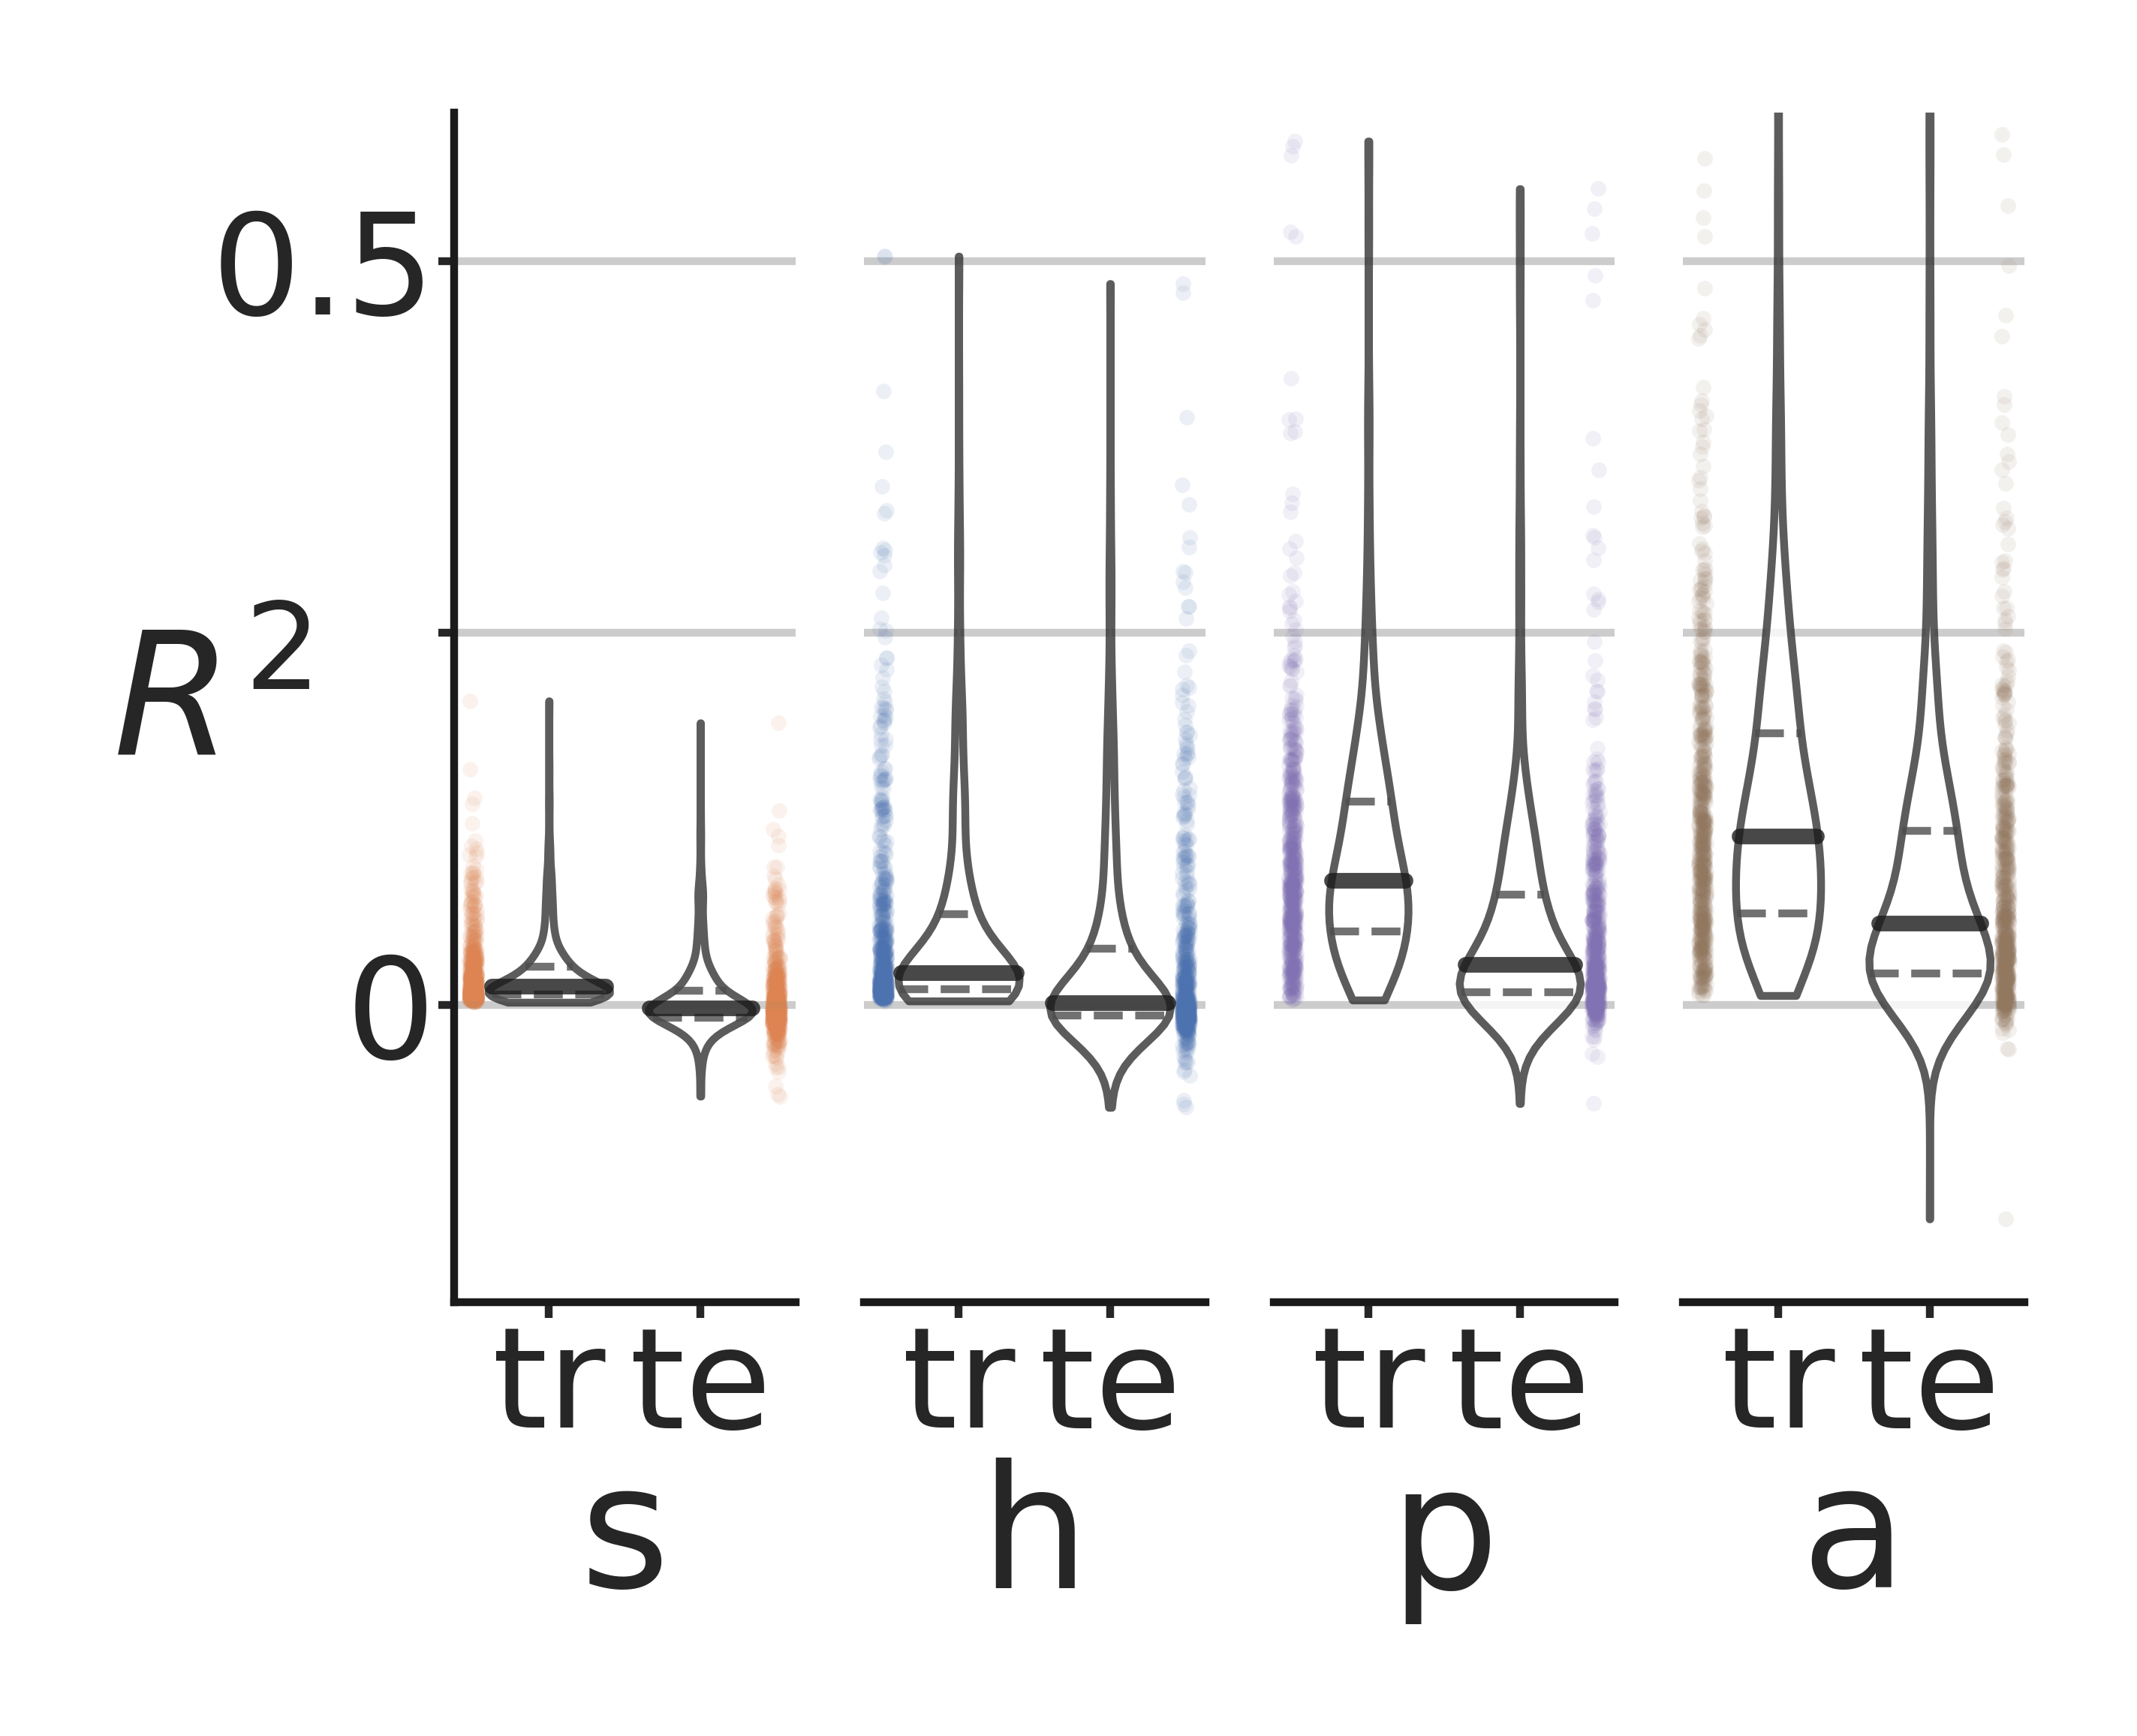

In [76]:
f3.plot_group_model_scores_h(figsize=(1.8, 1.4), metric='r2', save_format='svg', save_flag=True)

In [24]:
unit = 1288

@interact_manual
def move_model_tw(fold=range(5), idx=widgets.IntSlider(value=0,min=0, max=1000, step=50), wl=widgets.IntSlider(value=2000,min=500,max=2250, step=250), save_flag=[False, True]):
    f2.plot_model_resp_tw(cell_id=unit, fold=fold, idx=idx,wl=wl, save_flag=save_flag, 
                          figsize=(1.6,2.25), save_format='svg')

interactive(children=(Dropdown(description='fold', options=(0, 1, 2, 3, 4), value=0), IntSlider(value=0, descr…

In [13]:
units = f.model_examp_units

@interact()
def plot_model_resp_tw(cell_id=units, save_flag=[False,True]):
    print(unit_table.loc[cell_id, ['session', 'session_cl_id']])
    f.plot_model_resp_tw(cell_id=cell_id, save_flag=save_flag, figsize=(1.75,2.2), save_format='svg')


interactive(children=(Dropdown(description='cell_id', options=(648, 462, 1288, 3829, 314, 465), value=648), Dr…

(<Figure size 2250x3000 with 8 Axes>,
 array([[<AxesSubplot:ylabel='s'>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='d'>, <AxesSubplot:>],
        [<AxesSubplot:ylabel='p'>, <AxesSubplot:>],
        [<AxesSubplot:xlabel='$R^2$', ylabel='a'>,
         <AxesSubplot:xlabel='$r_p[m,\\hat{m}]$'>]], dtype=object))

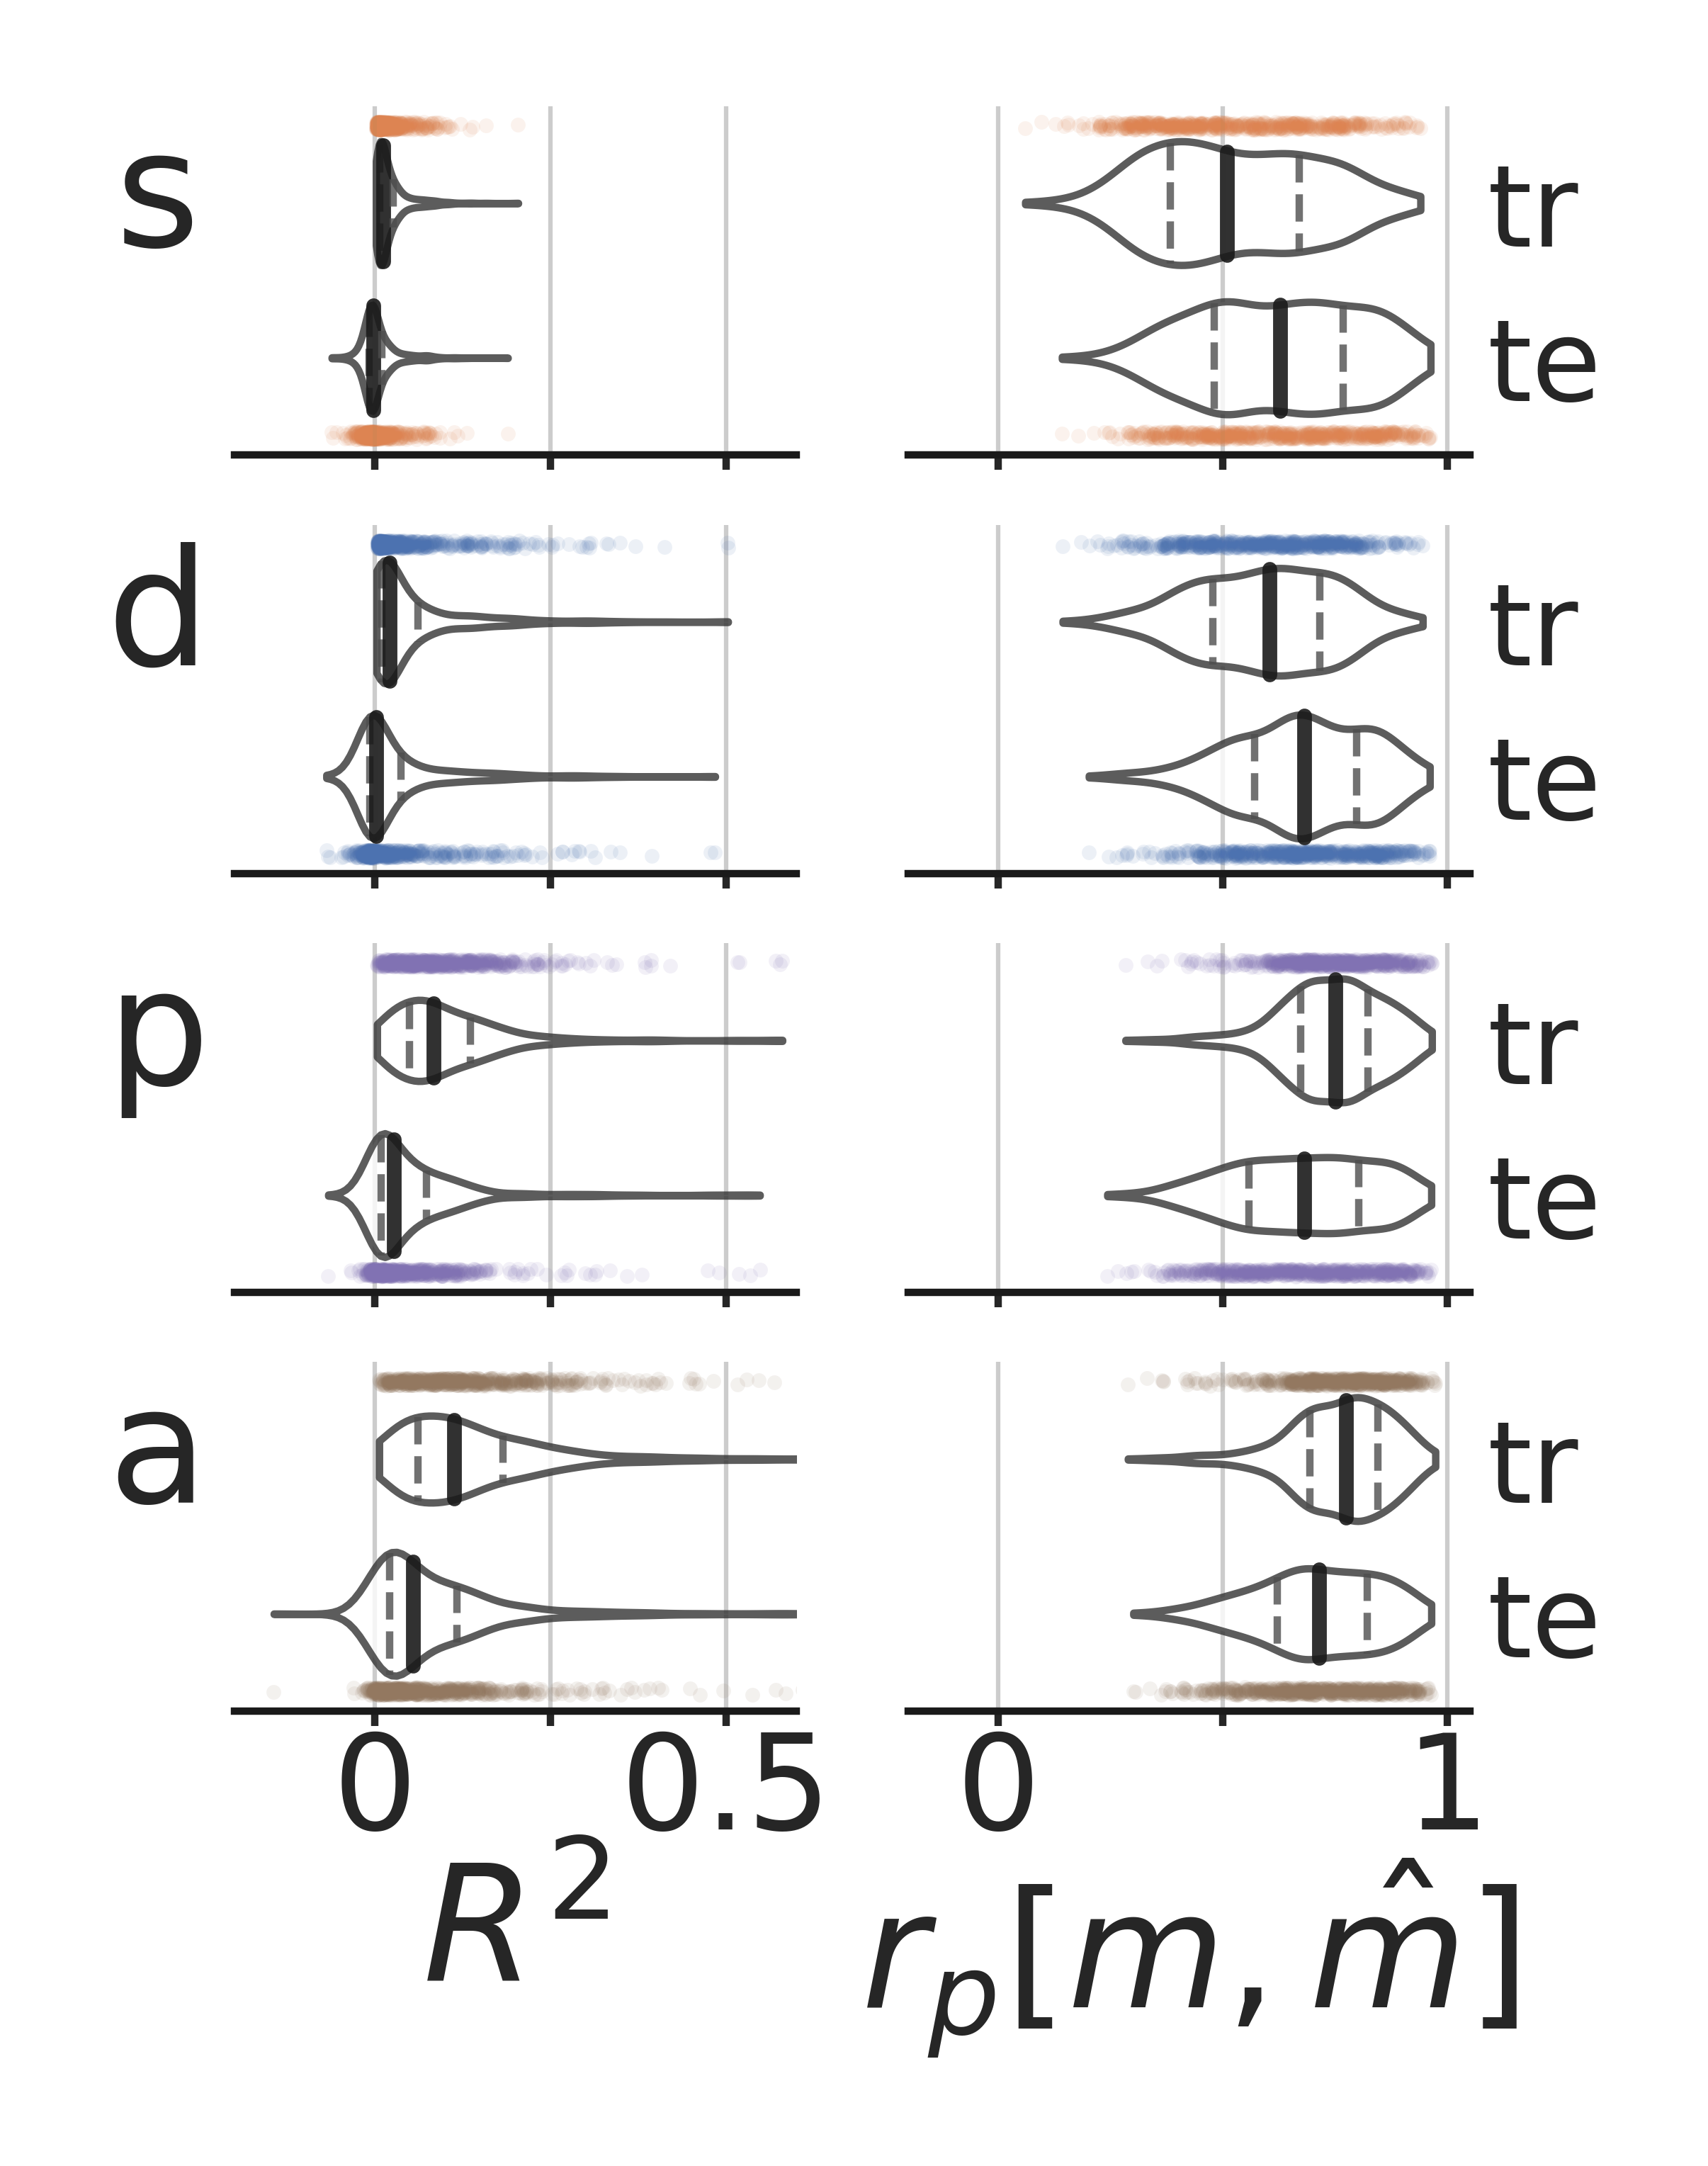

In [14]:
pf = reload(pf)
f = pf.OpenFieldFigures()

f.plot_group_model_scores_v(save_flag=False)

In [15]:
pf = reload(pf)
f = pf.OpenFieldFigures(model_analyses='new')
@interact
def foo(unit_type=['cell', 'mua', 'all', 'matched'], metric=['r2', 'map_r'], save_flag=[False,True]):
    f.plot_group_model_scores_h(unit_type=unit_type, metric=metric,save_flag=save_flag)
    

interactive(children=(Dropdown(description='unit_type', options=('cell', 'mua', 'all', 'matched'), value='cell…

In [16]:
ei = reload(ei)
info = ei.SummaryInfo()

_, m1 = info.get_of_results(model_analyses='orig')
_, m2 = info.get_of_results(model_analyses='new')
mt = info.get_unit_match_table()
mt2 = info.get_matched_of_cell_clusters()
m3 = info.get_combined_scores_matched_units()

In [89]:
exclude_units = m2[(m2.value<=-0.5) & (m2.metric=='r2')].unit_id.unique()
exclude_units = np.union1d(exclude_units, m2[m2.unit_type=='mua'].unit_id.unique())
valid_untis = np.setdiff1d(m2.unit_id.unique(), exclude_units)


m1s = m1[(m1.unit_id.isin(valid_untis)) & (m1.metric.isin(m2.metric.unique())) & (m1.model.isin(m2.model.unique()))].copy().reset_index()
m2s = m2[m2.unit_id.isin(valid_untis)].copy().reset_index()

In [90]:
exclude_units

array([   3,    4,    5, ..., 2214, 2216, 2218])

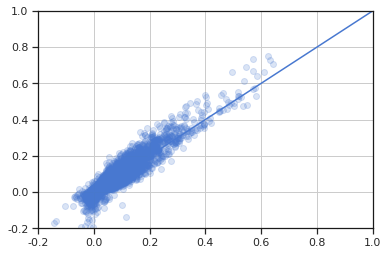

In [91]:
plt.scatter(m1s.loc[m1s.metric=='r2', 'value'], m2s.loc[m2s.metric=='r2','value'], alpha=0.2)
plt.xlim([-0.2,1])
plt.ylim([-0.2,1])
plt.plot([0,1],[0,1],)

In [101]:
m1s

index  unit_id subject       session  session_unit_id unit_type  \
0           4        0      Li  Li_OF_052818                0      cell   
1           5        0      Li  Li_OF_052818                0      cell   
2           6        0      Li  Li_OF_052818                0      cell   
3           7        0      Li  Li_OF_052818                0      cell   
4           8        0      Li  Li_OF_052818                0      cell   
...       ...      ...     ...           ...              ...       ...   
25797  195259     2219      Mi  Mi_OF_021820                0      cell   
25798  195260     2219      Mi  Mi_OF_021820                0      cell   
25799  195261     2219      Mi  Mi_OF_021820                0      cell   
25800  195262     2219      Mi  Mi_OF_021820                0      cell   
25801  195263     2219      Mi  Mi_OF_021820                0      cell   

       session_pct_cov  session_valid  tt  tt_cl    model  split  \
0                 0.96           True   7      8    speed   test   
1                 0.96           True   7      8    speed  train   
2                 0.96           True   7      8    speed   test   
3                 0.96           True   7      8    speed  train   
4                 0.96           True   7      8    speed   test   
...                ...            ...  ..    ...      ...    ...   
25797             0.92           True  14     11  agg_sdp  train   
25798             0.92           True  14     11  agg_sdp   test   
25799             0.92           True  14     11  agg_sdp  train   
25800             0.92           True  14     11  agg_sdp   test   
25801             0.92           True  14     11  agg_sdp  train   

             metric     value                         cl_name  
0      agg_sdp_coef  0.222397     Li_OF_052818-tt7_d17.25_cl8  
1      agg_sdp_coef  0.222397     Li_OF_052818-tt7_d17.25_cl8  
2              coef -0.569822     Li_OF_052818-tt7_d17.25_cl8  
3              coef -0.569822     Li_OF_052818-tt7_d17.25_cl8  
4             map_r  0.521373     Li_OF_052818-tt7_d17.25_cl8  
...             ...       ...                             ...  
25797         map_r  0.655752  Mi_OF_021820-tt14_d16.375_cl11  
25798         n_err  1.285556  Mi_OF_021820-tt14_d16.375_cl11  
25799         n_err  1.268204  Mi_OF_021820-tt14_d16.375_cl11  
25800            r2  0.029953  Mi_OF_021820-tt14_d16.375_cl11  
25801            r2  0.056372  Mi_OF_021820-tt14_d16.375_cl11  

[25802 rows x 15 columns]

In [102]:
m1sr2 = m1s.loc[m1s.metric=='r2', ['unit_id', 'model','subject', 'session', 'split', 'value']].copy()
m1sr2['model_analysis'] = 'orig'

m2sr2 = m2s.loc[m1s.metric=='r2', ['unit_id', 'model', 'subject','session', 'split', 'value']].copy()
m2sr2['model_analysis'] = 'new'

m3sr2= pd.concat((m1sr2, m2sr2))



In [103]:
m1sr2

unit_id    model subject       session  split     value model_analysis
8            0    speed      Li  Li_OF_052818   test -0.013688           orig
9            0    speed      Li  Li_OF_052818  train  0.028461           orig
18           1    speed      Li  Li_OF_052818   test -0.009104           orig
19           1    speed      Li  Li_OF_052818  train  0.007533           orig
28           2    speed      Li  Li_OF_052818   test -0.010236           orig
...        ...      ...     ...           ...    ...       ...            ...
25783     2219       hd      Mi  Mi_OF_021820  train  0.011316           orig
25792     2219      pos      Mi  Mi_OF_021820   test  0.012499           orig
25793     2219      pos      Mi  Mi_OF_021820  train  0.038157           orig
25800     2219  agg_sdp      Mi  Mi_OF_021820   test  0.029953           orig
25801     2219  agg_sdp      Mi  Mi_OF_021820  train  0.056372           orig

[5432 rows x 7 columns]

<AxesSubplot:xlabel='model', ylabel='value'>

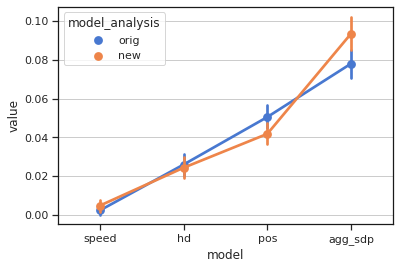

In [93]:
sns.pointplot(data=m3sr2[m3sr2.split=='test'], x='model', y='value', hue='model_analysis')

<AxesSubplot:xlabel='value', ylabel='Density'>

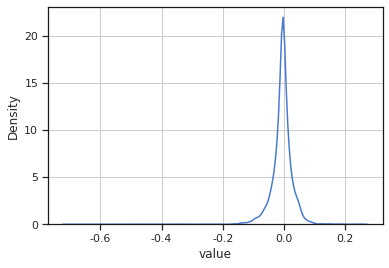

In [94]:
sns.kdeplot(m1s.loc[m1s.metric=='r2', 'value']- m2s.loc[m2s.metric=='r2','value'],)

In [99]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [104]:
table = m2sr2[m2sr2.split=='test'].copy()
table

unit_id    model subject       session split     value model_analysis
8            0    speed      Li  Li_OF_052818  test  0.009095            new
18           1    speed      Li  Li_OF_052818  test -0.016607            new
28           2    speed      Li  Li_OF_052818  test -0.009073            new
38           0       hd      Li  Li_OF_052818  test -0.031859            new
48           1       hd      Li  Li_OF_052818  test  0.019848            new
...        ...      ...     ...           ...   ...       ...            ...
25762     2217  agg_sdp      Mi  Mi_OF_021720  test  0.041835            new
25772     2219    speed      Mi  Mi_OF_021820  test  0.041633            new
25782     2219       hd      Mi  Mi_OF_021820  test -0.001531            new
25792     2219      pos      Mi  Mi_OF_021820  test  0.007160            new
25800     2219  agg_sdp      Mi  Mi_OF_021820  test  0.036608            new

[2716 rows x 7 columns]

## R2 stats

In [127]:
exclude_units = m2[(m2.value<=-0.5) & (m2.metric=='r2')].unit_id.unique()
exclude_units = np.union1d(exclude_units, m2[m2.unit_type=='mua'].unit_id.unique())
valid_untis = np.setdiff1d(m2.unit_id.unique(), exclude_units)

m2s = m2[m2.unit_id.isin(valid_untis)].copy().reset_index()
m2sr2 = m2s.loc[m1s.metric=='r2', ['unit_id', 'model', 'subject','session', 'split', 'value']].copy()
table = m2sr2[m2sr2.split=='test'].copy()

vc = {'unit_id': '0 + C(unit_id)'}
model_full = smf.mixedlm(formula="value ~ 1 + model",
                  groups='subject', re_formula='1', vc_formula=vc, data=table).fit()
model_no_inter = smf.mixedlm(formula="value ~ 1",
                  groups='subject', re_formula='1', vc_formula=vc, data=table).fit()

print(model_full.summary())
print()
print(model_full.wald_test_terms())
print()
print(model_no_inter.summary())
print(f"LRT = {2*(model_full.llf-model_no_inter.llf):0.2f}")

/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


          Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  value    
No. Observations:  2716     Method:              REML     
No. Groups:        6        Scale:               0.0045   
Min. group size:   24       Log-Likelihood:      3151.4894
Max. group size:   1208     Converged:           Yes      
Mean group size:   452.7                                  
----------------------------------------------------------
               Coef.  Std.Err.    z    P>|z| [0.025 0.975]
----------------------------------------------------------
Intercept       0.081    0.012   6.623 0.000  0.057  0.105
model[T.hd]    -0.069    0.004 -18.959 0.000 -0.076 -0.062
model[T.pos]   -0.052    0.004 -14.170 0.000 -0.059 -0.045
model[T.speed] -0.089    0.004 -24.315 0.000 -0.096 -0.082
subject Var     0.001    0.008                            
unit_id Var     0.002    0.003                            


                 chi2         P>chi2  df constraint
Intercept   4

/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [130]:
models = table.model.unique()
for m in models:
    table[m] = 0
    table.loc[table.model==m, m] = 1
table

unit_id    model subject       session split     value  speed  hd  pos  \
8            0    speed      Li  Li_OF_052818  test  0.009095      1   0    0   
18           1    speed      Li  Li_OF_052818  test -0.016607      1   0    0   
28           2    speed      Li  Li_OF_052818  test -0.009073      1   0    0   
38           0       hd      Li  Li_OF_052818  test -0.031859      0   1    0   
48           1       hd      Li  Li_OF_052818  test  0.019848      0   1    0   
...        ...      ...     ...           ...   ...       ...    ...  ..  ...   
25762     2217  agg_sdp      Mi  Mi_OF_021720  test  0.041835      0   0    0   
25772     2219    speed      Mi  Mi_OF_021820  test  0.041633      1   0    0   
25782     2219       hd      Mi  Mi_OF_021820  test -0.001531      0   1    0   
25792     2219      pos      Mi  Mi_OF_021820  test  0.007160      0   0    1   
25800     2219  agg_sdp      Mi  Mi_OF_021820  test  0.036608      0   0    0   

       agg_sdp  
8            0  
18           0  
28           0  
38           0  
48           0  
...        ...  
25762        1  
25772        0  
25782        0  
25792        0  
25800        1  

[2716 rows x 10 columns]

In [138]:
model_full = smf.mixedlm(formula="value ~ 0+speed+hd+pos+agg_sdp", groups='subject', re_formula='1', vc_formula=vc, data=table).fit()
print(model_full.summary())

model_no_agg = smf.mixedlm(formula="value ~ 0+speed+hd+pos", groups='subject', re_formula='1', vc_formula=vc, data=table).fit()
print(model_no_agg.summary())

LRT = 2*(model_full.llf-model_no_agg.llf)
chi2_p = stats.chi2.sf(LRT,1)
print(f"LRT = {LRT:0.2f}; Chi2_p={chi2_p}")

/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: value    
No. Observations: 2716    Method:             REML     
No. Groups:       6       Scale:              0.0045   
Min. group size:  24      Log-Likelihood:     3151.4894
Max. group size:  1208    Converged:          Yes      
Mean group size:  452.7                                
-------------------------------------------------------
             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
speed        -0.008    0.012 -0.637 0.524 -0.032  0.016
hd            0.012    0.012  0.962 0.336 -0.012  0.036
pos           0.029    0.012  2.392 0.017  0.005  0.053
agg_sdp       0.081    0.012  6.623 0.000  0.057  0.105
subject Var   0.001    0.008                           
unit_id Var   0.002    0.003                           

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: value    
No. Obser

/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [137]:
stats.chi2.sf(LRT,1)

0.009978078927304986

## map_r stats

In [145]:
exclude_units = np.union1d(exclude_units, m2[m2.unit_type=='mua'].unit_id.unique())
valid_untis = np.setdiff1d(m2.unit_id.unique(), exclude_units)

m2s = m2[m2.unit_id.isin(valid_untis)].copy().reset_index()
m2sm = m2s.loc[m1s.metric=='map_r', ['unit_id', 'model', 'subject','session', 'split', 'value']].copy()
table = m2sm[m2sm.split=='test'].copy()

models = table.model.unique()
for m in models:
    table[m] = 0
    table.loc[table.model==m, m] = 1
table

vc = {'unit_id': '0 + C(unit_id)',
     'session': '0 + session'}
model_full = smf.mixedlm(formula="value ~ 0+speed+pos+hd+agg_sdp",
                  groups='subject', re_formula='1', vc_formula=vc, data=table).fit()
model_no_agg = smf.mixedlm(formula="value ~ 0+speed+hd+pos",
                  groups='subject', re_formula='1', vc_formula=vc, data=table).fit()

print(model_full.summary())
print()
print(model_full.wald_test_terms())
print()
print(model_no_agg.summary())
LRT = 2*(model_full.llf-model_no_agg.llf)
chi2_p = stats.chi2.sf(LRT,1)
print(f"LRT = {LRT:0.2f}; Chi2_p={chi2_p}")

/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/statsmodels

        Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: value   
No. Observations: 2716    Method:             REML    
No. Groups:       6       Scale:              0.0227  
Min. group size:  24      Log-Likelihood:     948.9541
Max. group size:  1208    Converged:          No      
Mean group size:  452.7                               
------------------------------------------------------
              Coef. Std.Err.   z   P>|z| [0.025 0.975]
------------------------------------------------------
speed         0.110    0.060 1.847 0.065 -0.007  0.227
pos           0.262    0.060 4.394 0.000  0.145  0.379
hd            0.253    0.060 4.245 0.000  0.136  0.370
agg_sdp       0.382    0.060 6.404 0.000  0.265  0.498
subject Var   0.020                                   
session Var   0.003    0.008                          
unit_id Var   0.007    0.005                          


              chi2        P>chi2  df constraint
speed     3.412902  6.46

/home/alexgonzalez/anaconda3/envs/tm_analyses/lib/python3.9/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [123]:
#model_full.wald_test(np.array([[1,-1,0,0,0,0],[1,0,-1,0,0,0],[1,0,0,-1,0,0]]))
model_full.wald_test(np.array([1,-1,0,0,0,0]))

<class 'statsmodels.stats.contrast.ContrastResults'>
<Wald test (chi2): statistic=[[359.45288861]], p-value=3.704385184608714e-80, df_denom=1>

In [126]:
print(model_full.wald_test(np.array([1,0,-1,0,0,0])))
print(model_full.wald_test(np.array([1,0,0,-1,0,0])))

<Wald test (chi2): statistic=[[200.78011879]], p-value=1.411218085650144e-45, df_denom=1>
<Wald test (chi2): statistic=[[591.22289877]], p-value=1.358037281771423e-130, df_denom=1>


model[agg_sdp]    0.079840
model[hd]         0.010647
model[pos]        0.028127
model[speed]     -0.008900
dtype: float64

In [ ]:
table = m2sr2[m2sr2.split=='test'].copy()

model_full = smf.ols(formula="value ~ 1 + model", data=table).fit()
model_no_inter = smf.ols(formula="value ~ 1", data=table).fit()

print(model_full.summary())
print()
print(model_full.wald_test_terms())
print()
print(model_no_inter.summary())
print(f"LRT = {2*(model_full.llf-model_no_inter.llf):0.2f}")

model_full = smf.mixedlm(formula="score ~ -1 + of_coef*Cluster",
                  groups='subject', re_formula='1', data=table).fit()
model_no_inter = smf.mixedlm(formula="score ~ -1 + of_coef+Cluster",
                  groups='subject', re_formula='1', data=table).fit()

(-0.2, 0.6)

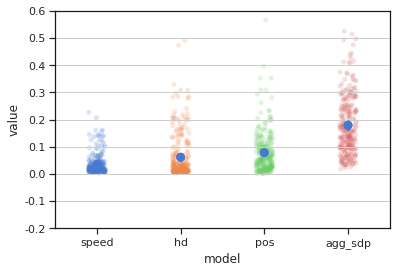

In [20]:
#t = model_scores[ (model_scores.unit_type=='cell') & (model_scores.split=='test')]
t =model_scores[model_scores.cl_name.isin(mt.cl_name_OF) & (model_scores.split=='train')]

ax=sns.pointplot(data=t[t.metric=='r2'], x='model', y='value', join=False,zorder=10)
ax=sns.stripplot(data=t[t.metric=='r2'], x='model', y='value', alpha=0.2,zorder=0)
#ax=sns.violinplot(data=t[t.metric=='r2'], x='model', y='value', color='w')
ax=sns.pointplot(data=t[t.metric=='r2'], x='model', y='value', join=False)
ax.set_ylim([-0.2,0.6])

In [177]:
ei = reload(ei)
info = ei.SummaryInfo()

_, m1 = info.get_of_results(model_analyses='orig')
_, m2 = info.get_of_results(model_analyses='new')
mt = info.get_unit_match_table()
mt2 = info.get_matched_of_cell_clusters()
m3 = info.get_combined_scores_matched_units()

In [180]:
print(m2.columns)
m2.head()

Index(['unit_id', 'subject', 'session', 'session_unit_id', 'unit_type',
       'session_pct_cov', 'session_valid', 'tt', 'tt_cl', 'model', 'split',
       'metric', 'value', 'cl_name'],
      dtype='object')


unit_id subject       session  session_unit_id unit_type  session_pct_cov  \
0        0      Li  Li_OF_052818                0      cell             0.96   
1        0      Li  Li_OF_052818                0      cell             0.96   
2        0      Li  Li_OF_052818                0      cell             0.96   
3        0      Li  Li_OF_052818                0      cell             0.96   
4        0      Li  Li_OF_052818                0      cell             0.96   

   session_valid  tt  tt_cl  model  split        metric     value  \
0           True   7      8  speed   test  agg_sdp_coef  0.613844   
1           True   7      8  speed  train  agg_sdp_coef  0.613844   
2           True   7      8  speed   test          coef -0.400811   
3           True   7      8  speed  train          coef -0.400811   
4           True   7      8  speed   test         map_r  0.093837   

                       cl_name  
0  Li_OF_052818-tt7_d17.25_cl8  
1  Li_OF_052818-tt7_d17.25_cl8  
2  Li_OF_052818-tt7_d17.25_cl8  
3  Li_OF_052818-tt7_d17.25_cl8  
4  Li_OF_052818-tt7_d17.25_cl8

In [ ]:
m2.pivot(index=['unit_id', 'model', 'split'], columns='value')

In [ ]:
# sel_cols = 'r2'
ss = 200
AA = m3[[s for s in m3.columns if sel_cols in s]].copy()

AA = AA.rename(columns={s:s.split('-')[1] for s in AA.columns})
Mag = AA[['pos','hd', 'speed']]
S = AA['agg_sdp']*ss

angles = np.arange(0,2*np.pi,2/3*np.pi)
ang_mat = np.tile(np.exp(angles*1j),[AA.shape[0],1])
R = (Mag*ang_mat).sum(axis=1)

f,ax=plt.subplots(subplot_kw={'projection':'polar'})
ax.scatter(np.angle(R), np.abs(R), s=S, lw=0, alpha=0.5,c = mt2['Cluster'], cmap='Set1_r')
mR = np.nanmean(R)
ax.plot([0,np.angle(mR)], [0,np.abs(mR)], lw=4, color='k', zorder=10)
ax.set_xticks(angles)
ax.set_xticklabels(['p', 'd', 's'])
ax.set_yticks([ 0.25, 0.5])

In [143]:
m3

match_cl_id subject  TM-remap_cue  TM-remap_rw  TM-stability_tm  \
0              0      Li     -0.477471    -0.992209         1.047540   
1              1      Li     -0.137774    -1.618546         0.734345   
2              2      Li     -0.183025    -0.372746         0.613068   
3              3      Li     -0.746639    -0.885057         0.796650   
4              4      Li           NaN          NaN              NaN   
..           ...     ...           ...          ...              ...   
212          212      Ca     -0.290551    -0.706569         0.317611   
213          213      Ca      0.621142     0.568547         0.205431   
214          214      Ca     -0.057788     0.316063         0.169561   
215          215      Ca     -0.010541     0.006612         0.259065   
216          216      Mi           NaN          NaN              NaN   

     TM-rate_cue  TM-rate_rw  TM-global_cue  TM-global_rw  TM-enc_uz_cue  ...  \
0       0.043149    0.064612       0.036118      0.063609      -0.831522  ...   
1       0.024987    0.078723       0.006386      0.055165      -0.869318  ...   
2       0.024433    0.059178       0.019781      0.063531      -0.907115  ...   
3       0.125429    0.096856       0.117374      0.074609      -0.302372  ...   
4            NaN         NaN            NaN           NaN            NaN  ...   
..           ...         ...            ...           ...            ...  ...   
212    -0.286214   -0.097742      -0.358769     -0.102196      -0.302372  ...   
213          NaN         NaN            NaN           NaN            NaN  ...   
214    -0.007369    0.002454      -0.017487           NaN      -1.360672  ...   
215    -0.000106   -0.004049      -0.014130     -0.024333      -2.267787  ...   
216          NaN         NaN            NaN           NaN            NaN  ...   

     OF-pos-r2  OF-speed-agg_sdp_coef  OF-speed-coef  OF-speed-map_r  \
0     0.010399               0.000691      -0.529173        0.267925   
1     0.008690               0.000465       0.105670        0.117091   
2     0.063096               0.001955      -0.141681        0.280153   
3     0.045507               0.004784       0.723135        0.396635   
4     0.090714               0.004766      -0.351496        0.278740   
..         ...                    ...            ...             ...   
212   0.047261               0.001503      -0.033209        0.318617   
213   0.066838               0.001614      -0.343481        0.235931   
214   0.040645               0.000645      -0.205140        0.252095   
215   0.009522               0.942832      -0.723043        0.114233   
216   0.173333               0.003132      -0.105422        0.220555   

     OF-speed-r2  OF-metric_score_border  OF-metric_score_grid  \
0       0.011840                0.026876                   NaN   
1       0.016422                0.378885                   NaN   
2       0.039950                0.410825             -0.116138   
3       0.138383                0.327252                   NaN   
4       0.013509               -0.280860             -0.214551   
..           ...                     ...                   ...   
212     0.030795                0.404300             -0.188767   
213     0.025657                0.604265             -0.155380   
214     0.010713                0.497950             -0.044624   
215     0.006009                0.515748                   NaN   
216     0.012405               -0.441498                   NaN   

     OF-metric_score_hd  OF-metric_score_speed  OF-metric_score_pos  
0              0.365053              -0.010321             0.290692  
1              0.055527               0.050962             0.442600  
2              0.052443               0.053874             0.425990  
3              0.033747               0.196234             0.290122  
4              0.855297              -0.019892             0.356961  
..                  ...                    ...                  ...  
212            0.03

(0.0, 0.75)

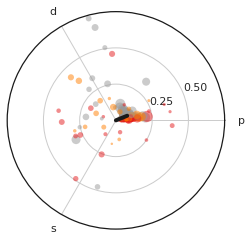

In [159]:
sel_cols = 'agg_sdp'
AA = m3[[s for s in m3.columns if sel_cols in s]].copy()
S = m3['OF-agg_sdp-r2']*200

AA = AA.rename(columns={s:s.split('-')[1] for s in AA.columns})

Mag = AA[['pos','hd', 'speed']]
Mag = Mag/np.percentile(Mag,95, axis=0)
angles = np.arange(0,2*np.pi,2/3*np.pi)
ang_mat = np.tile(np.exp(angles*1j),[AA.shape[0],1])
R = (Mag*ang_mat).sum(axis=1)

f,ax=plt.subplots(subplot_kw={'projection':'polar'})
ax.scatter(np.angle(R), np.abs(R), s=S, lw=0, alpha=0.5,c = mt2['Cluster'], cmap='Set1_r')
mR = np.nanmean(R)
ax.plot([0,np.angle(mR)], [0,np.abs(mR)], lw=4, color='k', zorder=10)
ax.set_xticks(angles)
ax.set_xticklabels(['p', 'd', 's'])
ax.set_yticks([ 0.25, 0.5])
ax.set_ylim([0,0.75])


In [154]:
Mag = AA[['pos','hd', 'speed']]
Mag = Mag/np.percentile(Mag,95, axis=0)
Mag

pos        hd     speed
0    0.032213  0.013123  0.000755
1    0.036087  0.004961  0.000507
2    0.082828  0.012807  0.002134
3    0.050688  0.012661  0.005224
4    0.085462  0.073115  0.005203
..        ...       ...       ...
212  0.063484  0.014417  0.001641
213  0.090357  0.011697  0.001762
214  0.076685  0.007009  0.000705
215  1.872300  0.982738  1.029428
216  0.132379  0.048409  0.003420

[217 rows x 3 columns]

In [153]:
np.percentile(Mag,95, axis=0)

array([0.22462618, 0.87846244, 0.72295378])

In [136]:
sel_cols = 'r2'
AA = m3[[s for s in m3.columns if sel_cols in s]].copy()

AA = AA.rename(columns={s:s.split('-')[1] for s in AA.columns})
AA

agg_sdp        hd       pos     speed
0    0.124067  0.125146  0.010399  0.011840
1    0.048706  0.022379  0.008690  0.016422
2    0.126936  0.012044  0.063096  0.039950
3    0.161722  0.020530  0.045507  0.138383
4    0.288238  0.223006  0.090714  0.013509
..        ...       ...       ...       ...
212  0.076337  0.011447  0.047261  0.030795
213  0.115281  0.008645  0.066838  0.025657
214  0.083604  0.008834  0.040645  0.010713
215  0.041426  0.007330  0.009522  0.006009
216  0.238103  0.039748  0.173333  0.012405

[217 rows x 4 columns]

In [125]:
m3

match_cl_id subject  TM-remap_cue  TM-remap_rw  TM-stability_tm  \
0              0      Li     -0.477471    -0.992209         1.047540   
1              1      Li     -0.137774    -1.618546         0.734345   
2              2      Li     -0.183025    -0.372746         0.613068   
3              3      Li     -0.746639    -0.885057         0.796650   
4              4      Li           NaN          NaN              NaN   
..           ...     ...           ...          ...              ...   
212          212      Ca     -0.290551    -0.706569         0.317611   
213          213      Ca      0.621142     0.568547         0.205431   
214          214      Ca     -0.057788     0.316063         0.169561   
215          215      Ca     -0.010541     0.006612         0.259065   
216          216      Mi           NaN          NaN              NaN   

     TM-rate_cue  TM-rate_rw  TM-global_cue  TM-global_rw  TM-enc_uz_cue  ...  \
0       0.043149    0.064612       0.036118      0.063609      -0.831522  ...   
1       0.024987    0.078723       0.006386      0.055165      -0.869318  ...   
2       0.024433    0.059178       0.019781      0.063531      -0.907115  ...   
3       0.125429    0.096856       0.117374      0.074609      -0.302372  ...   
4            NaN         NaN            NaN           NaN            NaN  ...   
..           ...         ...            ...           ...            ...  ...   
212    -0.286214   -0.097742      -0.358769     -0.102196      -0.302372  ...   
213          NaN         NaN            NaN           NaN            NaN  ...   
214    -0.007369    0.002454      -0.017487           NaN      -1.360672  ...   
215    -0.000106   -0.004049      -0.014130     -0.024333      -2.267787  ...   
216          NaN         NaN            NaN           NaN            NaN  ...   

     OF-pos-r2  OF-speed-agg_sdp_coef  OF-speed-coef  OF-speed-map_r  \
0     0.010399               0.000691      -0.529173        0.267925   
1     0.008690               0.000465       0.105670        0.117091   
2     0.063096               0.001955      -0.141681        0.280153   
3     0.045507               0.004784       0.723135        0.396635   
4     0.090714               0.004766      -0.351496        0.278740   
..         ...                    ...            ...             ...   
212   0.047261               0.001503      -0.033209        0.318617   
213   0.066838               0.001614      -0.343481        0.235931   
214   0.040645               0.000645      -0.205140        0.252095   
215   0.009522               0.942832      -0.723043        0.114233   
216   0.173333               0.003132      -0.105422        0.220555   

     OF-speed-r2  OF-metric_score_border  OF-metric_score_grid  \
0       0.011840                0.026876                   NaN   
1       0.016422                0.378885                   NaN   
2       0.039950                0.410825             -0.116138   
3       0.138383                0.327252                   NaN   
4       0.013509               -0.280860             -0.214551   
..           ...                     ...                   ...   
212     0.030795                0.404300             -0.188767   
213     0.025657                0.604265             -0.155380   
214     0.010713                0.497950             -0.044624   
215     0.006009                0.515748                   NaN   
216     0.012405               -0.441498                   NaN   

     OF-metric_score_hd  OF-metric_score_speed  OF-metric_score_pos  
0              0.365053              -0.010321             0.290692  
1              0.055527               0.050962             0.442600  
2              0.052443               0.053874             0.425990  
3              0.033747               0.196234             0.290122  
4              0.855297              -0.019892             0.356961  
..                  ...                    ...                  ...  
212            0.03

In [119]:
[s.split('-')[1] for s in AA.columns]

['hd', 'pos', 'speed']

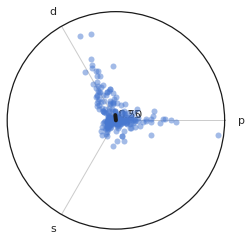

In [107]:
mm=m1
#metric ='r2'
metric = 'r2'
t =mm[mm.cl_name.isin(mt.cl_name_OF) & (mm.split=='test')]
A = t[t.metric==metric].pivot(index='unit_id',columns='model', values='value')
A[A<-0.2]=np.nan

AA = A[['pos','hd', 'speed']]
AA=rs.robust_zscore(AA,axis=0)
#AA=rs.zscore(AA.values,axis=0)
#AA=rs.zscore(AA.values,axis=1)

angles = np.arange(0,2*np.pi,2/3*np.pi)
ang_mat = np.tile(np.exp(angles*1j),[AA.shape[0],1])
R = (AA*ang_mat).sum(axis=1)

f,ax=plt.subplots(subplot_kw={'projection':'polar'})
ax.scatter(np.angle(R), np.abs(R), lw=0, alpha=0.5)
mR = np.nanmean(R)
ax.plot([0,np.angle(mR)], [0,np.abs(mR)], lw=4, color='k', zorder=10)
ax.set_xticks(angles)
ax.set_xticklabels(['p', 'd', 's'])
ax.set_yticks([ 0.25, 0.5])

In [109]:
A = t[t.metric==metric].pivot(index='unit_id',columns='model', values='value')

In [112]:
mm

unit_id subject       session  session_unit_id unit_type  \
0             0      Li  Li_OF_052818                0      cell   
1             0      Li  Li_OF_052818                0      cell   
2             0      Li  Li_OF_052818                0      cell   
3             0      Li  Li_OF_052818                0      cell   
4             0      Li  Li_OF_052818                0      cell   
...         ...     ...           ...              ...       ...   
195267     2219      Mi  Mi_OF_021820                0      cell   
195268     2219      Mi  Mi_OF_021820                0      cell   
195269     2219      Mi  Mi_OF_021820                0      cell   
195270     2219      Mi  Mi_OF_021820                0      cell   
195271     2219      Mi  Mi_OF_021820                0      cell   

        session_pct_cov  session_valid  tt  tt_cl     model  split  \
0                  0.96           True   7      8     speed   test   
1                  0.96           True   7      8     speed  train   
2                  0.96           True   7      8     speed   test   
3                  0.96           True   7      8     speed  train   
4                  0.96           True   7      8     speed   test   
...                 ...            ...  ..    ...       ...    ...   
195267             0.92           True  14     11  agg_sdbg  train   
195268             0.92           True  14     11  agg_sdbg   test   
195269             0.92           True  14     11  agg_sdbg  train   
195270             0.92           True  14     11  agg_sdbg   test   
195271             0.92           True  14     11  agg_sdbg  train   

               metric     value                         cl_name  
0        agg_all_coef  0.223190     Li_OF_052818-tt7_d17.25_cl8  
1        agg_all_coef  0.223190     Li_OF_052818-tt7_d17.25_cl8  
2       agg_sdbg_coef  0.353739     Li_OF_052818-tt7_d17.25_cl8  
3       agg_sdbg_coef  0.353739     Li_OF_052818-tt7_d17.25_cl8  
4        agg_sdp_coef  0.222397     Li_OF_052818-tt7_d17.25_cl8  
...               ...       ...                             ...  
195267          map_r  0.626103  Mi_OF_021820-tt14_d16.375_cl11  
195268          n_err  1.284610  Mi_OF_021820-tt14_d16.375_cl11  
195269          n_err  1.281156  Mi_OF_021820-tt14_d16.375_cl11  
195270             r2  0.031378  Mi_OF_021820-tt14_d16.375_cl11  
195271             r2  0.036998  Mi_OF_021820-tt14_d16.375_cl11  

[195272 rows x 14 columns]

[Text(0.0, 0, 'p'),
 Text(2.0943951023931953, 0, 'd'),
 Text(4.1887902047863905, 0, 's')]

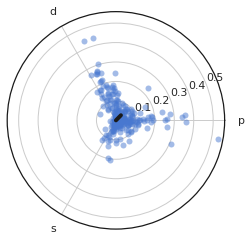

In [103]:
mm=m2
t =mm[mm.cl_name.isin(mt.cl_name_OF) & (mm.split=='test')]
A = t[t.metric==metric].pivot(index='unit_id',columns='model', values='value')
A[A<-0.2]=np.nan

AA = A[['pos','hd', 'speed']]
#AA=rs.robust_zscore(AA,axis=0)
angles = np.arange(0,2*np.pi,2/3*np.pi)
ang_mat = np.tile(np.exp(angles*1j),[AA.shape[0],1])
R = (AA*ang_mat).sum(axis=1)

f,ax=plt.subplots(subplot_kw={'projection':'polar'})
ax.scatter(np.angle(R), np.abs(R), lw=0, alpha=0.5)
mR = np.nanmean(R)
ax.plot([0,np.angle(mR)], [0,np.abs(mR)], lw=4, color='k', zorder=10)
ax.set_xticks(angles)
ax.set_xticklabels(['p', 'd', 's'])
#ax.set_yticks([ 0.25, 0.5])
#ax.set_ylim([0,10])

In [74]:
(A*ang_mat).sum(axis=1)

unit_id
290    -0.040230+0.090293j
293    -0.071446+0.237006j
294    -0.094820+0.261511j
295    -0.037577+0.234795j
296    -0.120200+0.321959j
               ...        
2138   -0.067971+0.123540j
2149   -0.136777+0.253548j
2150   -0.118518+0.215809j
2164   -2.578469+4.466232j
2199   -0.170764+0.370799j
Length: 262, dtype: complex128

In [72]:
rs.robust_zscore(A)

model           hd        pos      speed
unit_id                                 
290      -0.525957   0.626830  -0.674486
293       0.192512   2.792142  -0.623630
294       0.052387   3.120341  -0.648614
295       0.594451   2.755416  -0.628501
296       0.202695   4.023017  -0.617124
...            ...        ...        ...
2138     -0.637053   1.101550  -0.678930
2149     -0.543028   2.991224  -0.662964
2150     -0.599173   2.435231  -0.675055
2164     11.086082  75.452922  11.084687
2199     -0.103370   4.700007  -0.644019

[262 rows x 3 columns]

In [33]:
R

unit_id
290     0.098311+0.010306j
293     0.240976+0.056629j
294     0.273885+0.048639j
295     0.222127+0.084855j
296     0.338925+0.056884j
               ...        
2138    0.140974+0.002906j
2149    0.287968+0.008322j
2150    0.246155+0.005265j
2164    5.157105+0.000097j
2199    0.406503+0.037513j
Length: 262, dtype: complex128

<AxesSubplot:xlabel='model', ylabel='value'>

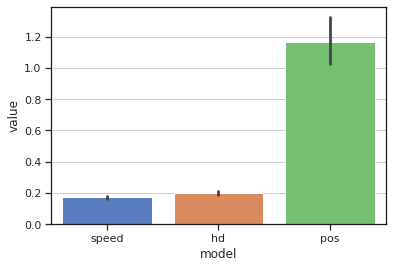

In [18]:
sns.barplot(data=m2[m2.metric=='agg_sdp_coef'],x='model', y='value')

<AxesSubplot:xlabel='model', ylabel='value'>

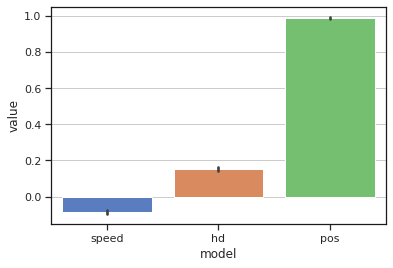

In [19]:
sns.barplot(data=m1[m1.metric=='agg_sdp_coef'],x='model', y='value')

In [ ]:
label_fontsize=9
tick_fontsize=7
dpi=1200
type_color = {'hd': analyses_colors[0],
              'speed': analyses_colors[1],
              'border': analyses_colors[2],
              'grid': analyses_colors[3],
              'pos': analyses_colors[4]}


for unit_type in ['cell']:#['cell', 'mua']:
    
    #f, ax = plt.subplots(5,2, figsize=(2.8,3), constrained_layout=True, dpi=600)
    f, ax = plt.subplots(5,2, figsize=(2.8,2.8), dpi=600)
    for jj, metric in enumerate(['r2', 'map_r']):
        analyses = ['speed', 'hd', 'border', 'grid', 'pos']
        sns.set_style('whitegrid')
        for ii, analysis in enumerate(analyses):
            data_subset = model_scores[ (model_scores['unit_type']==unit_type) & 
                                        (model_scores['model']==analysis) & 
                                        (model_scores['metric']==metric) &
                                        (model_scores['session_valid']) 
                                      ]
            data_subset = data_subset[~data_subset.isin([np.nan, np.inf, -np.inf]).any(1)]

            #sns.boxplot(data=data_subset, x='value', y='split', color='white', whis=100, ax=ax[ii])
            sns.violinplot(data=data_subset, x='value', y='split', color='white', order=['train','test'], cut=0, ax=ax[ii,jj],inner='quartile', linewidth=0.5)  
            #sns.stripplot(data=data_subset, x='value', y='split', color=type_color[analysis], alpha=0.2, ax=ax[ii])

            for l in ax[ii,jj].lines:
                l.set_linestyle('--')
                l.set_linewidth(0.5)
                l.set_color('0.3')
                l.set_alpha(0.8)
            for l in ax[ii,jj].lines[1::3]:
                l.set_linestyle('-')
                l.set_linewidth(1)
                l.set_color('0.1')
                l.set_alpha(0.8)
            for c in ax[ii,jj].collections:
                c.set_edgecolor('0.2')
                #c.set_linewidth(1.5)
                c.set_alpha(0.8)

            split_points = data_subset.split == 'train'
            ax[ii,jj].scatter(x=data_subset['value'][split_points], y=-0.5 + 0.05*(np.random.rand(split_points.sum())-0.5),
                           s=1, facecolor=type_color[analysis], alpha=0.1,  edgecolors=None, linewidth=0)

            split_points = data_subset.split == 'test'
            ax[ii,jj].scatter(x=data_subset['value'][split_points], y=1.5 + 0.05*(np.random.rand(split_points.sum())-0.5),
                           s=1, facecolor=type_color[analysis], alpha=0.1, edgecolors=None, linewidth=0)


            if metric=='r2':
                ax[ii,jj].set_xlabel(r'$R^2$', fontsize=label_fontsize, va='center')
                if unit_type=='cell':
                    ax[ii,jj].set_xlim([-0.15,0.45])
                else:
                    ax[ii,jj].set_xlim([-0.2,0.45])
            elif metric=='map_r':
                ax[ii,jj].set_xlabel(r'$r_p[m,\hat{m}]$', fontsize=label_fontsize, va='center')
                ax[ii,jj].set_xlim([-0.05,1.05])

            if ii==4:
                xticks = ax[ii,jj].get_xticks() 
                if metric=='map_r':
                    ax[ii,jj].set_xticks([0,1])
                    ax[ii,jj].set_xticklabels([0, '1'], fontsize=tick_fontsize, va='center')
                else:
                    ax[ii,jj].set_xticklabels(np.around(xticks,1), fontsize=tick_fontsize, va='center')
                
                xticklabels=ax[ii,jj].get_xticklabels() 
                for l in xticklabels:
                    pos = l.get_position()
                    l.set_position((pos[0], pos[1]+0.2))
                ax[ii,jj].set_xticklabels(xticklabels, fontsize=tick_fontsize)
                
            else:
                ax[ii,jj].set_xticklabels([])
           
            if ii<4:
                ax[ii,jj].set_xlabel('')
                
            if jj==0:
                ax[ii, jj].set_ylabel(analysis, fontsize=label_fontsize)
                ax[ii, jj].set_yticklabels(['train', 'test'], fontsize=tick_fontsize, ha='left')
            else:
                ax[ii,jj].set_ylabel('')
                ax[ii,jj].set_yticklabels([])
            
            for pos in ['right', 'top', 'left']:
                ax[ii,jj].spines[pos].set_visible(False)


#f.savefig(fig5_path/(f'ModelScores_{unit_type}.pdf'), bbox_inches='tight', dpi=dpi)
#f.savefig(fig5_path/(f'ModelScores_{unit_type}.png'), bbox_inches='tight', dpi=dpi)

In [15]:
ei = reload(ei)
info = ei.SummaryInfo()
info.update_paths()

In [16]:
subject_widget = widgets.Dropdown(options=info.subjects)
session_widget = widgets.Dropdown(options=info.sessions_by_subject[subject_widget.value])
task_widget = widgets.Dropdown(options=['T3', 'OF'])

def update_sessions(*args):
    all_sessions = info.sessions_by_subject[subject_widget.value]
    task_sessions = [session for session in all_sessions if task_widget.value in session]
    session_widget.options = task_sessions

def get_session(subject, task, session):
    return ei.SubjectSessionInfo(subject, session)

subject_widget.observe(update_sessions, names='value')
task_widget.observe(update_sessions, names='value')
o=widgets.interactive(get_session, subject=subject_widget, task=task_widget, session=session_widget)
display(o)

interactive(children=(Dropdown(description='subject', options=('Li', 'Ne', 'Cl', 'Al', 'Ca', 'Mi'), value='Li'…

In [17]:
session = session_widget.value
session_info = o.result
print(session_info)


Session Information for subject Li, session Li_T3g_052818
Number of curated units: 2
Methods listed below can be executed with get_{method}(), eg. get_spikes():
  -> track_data. Executed = True
  -> spikes. Executed = True
  -> binned_spikes. Executed = True
  -> fr. Executed = True
  -> pos_zones. Executed = True
  -> event_table. Executed = True
  -> trial_zone_rates. Executed = False
  -> zone_rates_comps. Executed = True
  -> zone_rates_remap. Executed = True
  -> pop_zone_rates_remap. Executed = True
  -> bal_conds_seg_rates. Executed = True
  -> bal_conds_seg_boot_rates. Executed = nan
  -> zone_encoder. Executed = True
  -> zone_decoder. Executed = True

To run all analyses use run_analyses().



In [18]:
models='sdp'
secs_per_split = 45
session_info.get_encoding_models(save_flag=True, **dict(models=models, secs_per_split=secs_per_split))

KeyError: 'OF_encoding_models_obj'

In [ ]:
session_info.paths

In [ ]:
# %%time
# sf = reload(sf)
# of = reload(of)
# models='sdp'
# secs_per_split = 45
# sem = of.get_session_encoding_models(session_info, models=models, secs_per_split=secs_per_split)
# scores=sem.get_scores()
# scores

In [ ]:
pf = reload(pf)
unit = 19
fold=0

ww = 2250
ii=0
idx=0 + ii*ww
wl=ww
time_window = np.arange(wl) + idx

pf.plot_models_resp_tw(sem, unit, fold, idx, wl, plot_rm=True, plot_o=True, fig_size=(1.5,1.8))

In [ ]:
self = f
cell_id = 314
if cell_id in self.model_examp_units:
    unit_idx = np.where(self.model_examp_units==cell_id)[0]
    unit_plot_params = self.model_examps_params[int(unit_idx)]
    assert(unit_plot_params['unit']==cell_id)

In [ ]:
unit_plot_params, cell_id, unit_idx, self.model_examps_params, self.model_examp_units

In [ ]:
models_resp = sem.get_models_predictions(unit)

In [ ]:
plt.scatter(x_tw,y_tw, models_resp['o'][tw_samps]*0.2)

In [ ]:
tw_samps

In [ ]:
models_resp['o'][tw_samps]

In [ ]:
unit = 10
fold=3

idx=2000 
wl=1000
time_window = np.arange(wl) + idx

models = ['o', 's', 'd', 'p', 'a']
    
def get_tw_txy(sem, fold, time_window=None, model='o', test=True):
    samples = np.arange(sem.n_samples)
    if test:
        fold_test_ids_bool = sem.crossval_samp_ids==fold
    else:
        fold_test_ids_bool = sem.crossval_samp_ids!=fold
    sp_valid_ids_bool = sem.valid_sp_samps

    fold_test_samples = samples[fold_test_ids_bool]
    if time_window is not None:
        fold_test_window_samples = fold_test_samples[time_window]
    else:
        fold_test_window_samples = fold_test_samples

    fold_test_samples_sp = samples[fold_test_ids_bool & sp_valid_ids_bool]
    fold_test_window_samples_sp = np.intersect1d(fold_test_samples_sp,fold_test_window_samples)
    
    if model in ['s','d']:
        t = behav['t'][fold_test_window_samples_sp]
        x = sem.x[fold_test_window_samples_sp]
        y = sem.y[fold_test_window_samples_sp]
    else:
        t = behav['t'][fold_test_window_samples]
        x = sem.x[fold_test_window_samples]
        y = sem.y[fold_test_window_samples]
    return t,x,y
        
def get_model_responses(sem, unit, fold, time_window ):
    
    samples = np.arange(sem.n_samples)
    fold_test_ids_bool = sem.crossval_samp_ids==fold
    sp_valid_ids_bool = sem.valid_sp_samps

    fold_test_samples = samples[fold_test_ids_bool]
    fold_test_window_samples = fold_test_samples[time_window]

    fold_test_samples_sp = samples[fold_test_ids_bool & sp_valid_ids_bool]
    fold_test_window_samples_sp = np.intersect1d(fold_test_samples_sp,fold_test_window_samples)

    within_fold_samples = np.arange(len(fold_test_samples))
    within_fold_window_samples = time_window

    within_fold_samples_sp = np.arange(len(fold_test_samples_sp))
    within_fold_window_samples_sp = time_window[np.in1d(fold_test_window_samples, fold_test_window_samples_sp)]

    
    models = ['o', 's', 'd', 'p', 'a']
    
    # responses
    resp = {}
    resp['o'] = sem.pos_model.get_response_fold(fold)[1][unit, within_fold_window_samples]

    resp['s'] = sem.speed_model.predict_model_fold(fold)[1][unit, within_fold_window_samples_sp]
    resp['d']= sem.hd_model.predict_model_fold(fold)[1][unit, within_fold_window_samples_sp]

    resp['p'] = sem.pos_model.predict_model_fold(fold)[1][unit, within_fold_window_samples]
    resp['a'] = sem.agg_sdp_model.predict_model_fold(fold)[1][unit, within_fold_window_samples]
    
    # spatial maps
    sm = {}
    for m in models:
        resp[m] = resp[m]/resp[m].max()
        if m in ['s', 'd']:
            x_win = sem.x[fold_test_window_samples_sp]
            y_win = sem.y[fold_test_window_samples_sp]
        else:
            x_win = sem.x[fold_test_window_samples]
            y_win = sem.y[fold_test_window_samples]

        #sm[m] = sem.spatial_map_function(resp[m],x_win,y_win)
        sm[m]=sf.firing_rate_2_rate_map(resp[m], x_win, y_win, 
                                        params['x_bin_edges_'], params['y_bin_edges_'], 
                                        occ_num_thr=1, spatial_window_size=4, apply_median_filt=False)
        #sm[m][sm[m]==0]=np.nan

    return resp, sm

model_resp, model_sm = get_model_responses(sem, unit, fold, time_window)
model_resp2, model_sm2 = get_model_responses(sem2, unit, fold, time_window)


In [ ]:
unit = 10
fold=3

idx=500
wl=1500
time_window = np.arange(wl) + idx

label_fontsize= 9
tick_fontsize=7

def plot_models_resp_tw(sem, unit, fold, time_window):
    
    models_resp, models_sm = get_model_responses(sem, unit, fold, time_window )
    
    f = plt.figure(figsize=(2,2), dpi=600)
    gs = f.add_gridspec(6,3,)
    ax = [[]]*12
    for ii in range(5):
        jj = ii*2
        ax[jj] = f.add_subplot(gs[ii, :2])
        ax[jj+1] = f.add_subplot(gs[ii, 2])
        
    analyses_colors = sns.color_palette(palette='deep', as_cmap=True)
    type_color = {'o': 'k',
                  'd': analyses_colors[0],
                  's': analyses_colors[1],
                  'p': analyses_colors[4],
                  'a': analyses_colors[5]}
    cmap='rainbow'
    wl = len(time_window)
    colors = plt.cm.get_cmap(cmap)(np.arange(wl)/wl)
    n_time = np.arange(wl)/wl
    # time
    pf.colorline(n_time, np.ones_like(n_time) ,colors=colors,linewidth=5, ax=ax[0])
    ax[0].set_ylim([0.8,1.2])
    #ax[0].set_xlim([time_window[0], time_window[-1]])
    ax[0].text(1,0.8, f"{wl*0.02:0.0f}s", fontsize=tick_fontsize, ha='right')
    for pos in ['left', 'top', 'right', 'bottom']:
            ax[0].spines[pos].set_visible(False)
    ax[0].set_yticks([])
    ax[0].set_yticklabels('')
    ax[0].set_xticks([])
    ax[0].set_xticklabels('')
    ax[0].set_ylabel('t', fontsize=label_fontsize, va='center', ha='right',  rotation=0)

    tw_t,tw_x,tw_y = get_tw_txy(sem, fold,time_window)

    pf.colorline(tw_x, tw_y, colors=colors, linewidth=1, ax=ax[1], alpha=1)
    
    tw_t_tr,tw_x_tr,tw_y_tr = get_tw_txy(sem, fold,time_window=None, test=False)
    ax[1].plot(tw_x_tr,tw_y_tr, linewidth=0.1, color='0.7',zorder=-1)
    ax[1].scatter(tw_x, tw_y, s=models_resp['o']*.5,  color='0.1' , alpha=0.3, edgecolors=None, linewidth=0)
    ax[1].axis("off")
    ax[1].set_rasterized(True)
    ax[1].set_aspect('equal', 'box')
    p = ax[1].get_position()
    ax[1].set_position([p.x0-0.06, p.y0, p.width*1.1, p.height*1.1])

    # plot models
    for ii,model in enumerate(models):
        if model=='o':
            continue
        jj = (ii-1)*2+3
        sns.heatmap(models_sm[model],ax=ax[jj],cbar=False,square=True, vmin=0, vmax=1, cmap='gist_heat')
        ax[jj].axis('off')
        ax[jj].invert_yaxis()
        ax[jj].set_rasterized(True)

        p = ax[jj].get_position()
        ax[jj].set_position([p.x0-0.06, p.y0, p.width*1.1, p.height*1.1])

    for ii,model in enumerate(models):
        if model=='o':
            continue
        jj = (ii-1)*2+2
        tw,_,_ = get_tw_txy(sem, fold, time_window, model)

        ax[jj].plot(tw_t, models_resp['o'], linewidth=0.5, ls='--', color=type_color['o'], alpha=0.7)
        ax[jj].plot(tw, models_resp[model], linewidth=0.75, color=type_color[model])
        ax[jj].set_yticks([])
        ax[jj].set_xticks([])
        ax[jj].set_yticklabels('')
        ax[jj].set_xticklabels('')
        ax[jj].grid(False)
        for pos in ['left', 'top', 'right', 'bottom']:
            ax[jj].spines[pos].set_visible(False)
        ax[jj].set_ylabel(model, fontsize=label_fontsize, rotation=0, ha='right', va='center')
        
plot_models_resp_tw(sem2, unit, fold, time_window)

In [ ]:
unit_table[(unit_table.session==session)&(unit_table.session_cl_id==unit)]

In [ ]:
plot_models_resp_tw(sem2, 4, fold, time_window)

In [ ]:
unit = 10
fold=3

idx=500
wl=1500
time_window = np.arange(wl) + idx

label_fontsize= 9
tick_fontsize=7

def plot_models_resp_tw(sem, unit, fold, time_window):
    
    models_resp, models_sm = get_model_responses(sem, unit, fold, time_window )
    
    f = plt.figure(figsize=(2,2), dpi=600)
    gs = f.add_gridspec(6,3,)
    ax = [[]]*12
    for ii in range(6):
        jj = ii*2
        ax[jj] = f.add_subplot(gs[ii, :2])
        ax[jj+1] = f.add_subplot(gs[ii, 2])
        
    analyses_colors = sns.color_palette(palette='deep', as_cmap=True)
    type_color = {'o': 'k',
                  'd': analyses_colors[0],
                  's': analyses_colors[1],
                  'p': analyses_colors[4],
                  'a': analyses_colors[5]}
    cmap='rainbow'
    wl = len(time_window)
    colors = plt.cm.get_cmap(cmap)(np.arange(wl)/wl)
    n_time = np.arange(wl)/wl
    # time
    pf.colorline(n_time, np.ones_like(n_time) ,colors=colors,linewidth=5, ax=ax[0])
    ax[0].set_ylim([0.8,1.2])
    #ax[0].set_xlim([time_window[0], time_window[-1]])
    ax[0].text(1,0.8, f"{wl*0.02:0.0f}s", fontsize=tick_fontsize, ha='right')
    for pos in ['left', 'top', 'right', 'bottom']:
            ax[0].spines[pos].set_visible(False)
    ax[0].set_yticks([])
    ax[0].set_yticklabels('')
    ax[0].set_xticks([])
    ax[0].set_xticklabels('')
    ax[0].set_ylabel('t', fontsize=label_fontsize, va='center', ha='right',  rotation=0)

    tw_t,tw_x,tw_y = get_tw_txy(sem, fold,time_window)

    pf.colorline(tw_x, tw_y, colors=colors, linewidth=1, ax=ax[1], alpha=1)
    ax[1].plot(sem.x,sem.y, linewidth=0.1, color='0.7',zorder=-1)
    ax[1].scatter(tw_x, tw_y, s=models_resp['o']*.5,  color='0.1' , alpha=0.3, edgecolors=None, linewidth=0)
    ax[1].axis("off")
    ax[1].set_rasterized(True)
    ax[1].set_aspect('equal', 'box')
    p = ax[1].get_position()
    ax[1].set_position([p.x0-0.06, p.y0, p.width*1.1, p.height*1.1])

    # plot models
    for ii,model in enumerate(models):
        jj = ii*2+3
        sns.heatmap(models_sm[model],ax=ax[jj],cbar=False,square=True, vmin=0, vmax=1, cmap='plasma')
        ax[jj].axis('off')
        ax[jj].invert_yaxis()
        ax[jj].set_rasterized(True)

        p = ax[jj].get_position()
        ax[jj].set_position([p.x0-0.06, p.y0, p.width*1.1, p.height*1.1])

    for ii,model in enumerate(models):
        jj = ii*2+2
        
        tw,_,_ = get_tw_txy(sem, fold, time_window, model)

        ax[jj].plot(tw, models_resp[model], linewidth=0.5, color=type_color[model])
        ax[jj].set_yticks([])
        ax[jj].set_xticks([])
        ax[jj].set_yticklabels('')
        ax[jj].set_xticklabels('')
        ax[jj].grid(False)
        for pos in ['left', 'top', 'right', 'bottom']:
            ax[jj].spines[pos].set_visible(False)
        ax[jj].set_ylabel(model, fontsize=label_fontsize, rotation=0, ha='right', va='center')
        
plot_models_resp_tw(sem2, unit, fold, time_window)

In [ ]:
sns.heatmap(sem2.pos_model.feature_inverse(sem2.get_coefs('pos')[fold][unit]).reshape(47,42))

In [ ]:
sem.get_coefs('agg_sdp')[fold][unit]

In [ ]:
sns.heatmap(sem2.
            (sem2.neural_data[5],sem2.x,sem2.y))

In [ ]:
sns.heatmap(sf.firing_rate_2_rate_map(sem2.neural_data[5],sem2.x,sem2.y,params['x_bin_edges_'], params['y_bin_edges_']))

In [ ]:
unit_table

In [ ]:
sns.heatmap(sf.firing_rate_2_rate_map(fr2[5],x,y,params['x_bin_edges_'], params['y_bin_edges_']))

## trying zscoring of models

In [ ]:
of = reload(of)
m = of.get_session_encoding_models(session_info, models='sdp', norm_resp='zscore', secs_per_split=30.0)

In [ ]:
# get data
models = 'sdp'
norm_resp='zscore'
secs_per_split = 60 

fr = session_info.get_fr()

of_dat = SimpleNamespace(**session_info.get_track_data())
task_params = session_info.task_params

sem = of.AllSpatialEncodingModels(x=of_dat.x, y=of_dat.y, speed=of_dat.sp, ha=of_dat.ha,
                               hd=of_dat.hd, neural_data=fr, n_jobs=10, models=models, norm_resp=norm_resp, 
                               secs_per_split=secs_per_split, **task_params)

In [ ]:
from scipy.interpolate import SmoothBivariateSpline, LSQBivariateSpline, RectBivariateSpline

In [ ]:
sr = SmoothBivariateSpline(of_dat.x, of_dat.y, fr[5])
a,b=sr.get_knots()
a.shape, b.shape

In [ ]:

sr.ev(0,0)

In [ ]:
xs,ys=np.meshgrid(np.arange(-50,50), np.arange(-20,150))
sns.heatmap(sr.ev(xs.flatten(), ys.flatten()).reshape(100,170).T)

In [ ]:
unit = 5
zfr = rs.zscore(fr[unit])
step=15
bbox = [-65,65,-20,150]
tx = np.arange(-65,65, step)
ty = np.arange(-20,150, step)
kk = 2
eps = 0.01
#lsq_s = LSQBivariateSpline(of_dat.x, of_dat.y, fr[5], tx=tx, ty=ty, kx=1,ky=1, bbox=bbox)
lsq_s = LSQBivariateSpline(of_dat.x, of_dat.y, zfr, tx=tx, ty=ty, kx=kk,ky=kk, eps=eps)
#lsq_s = SmoothBivariateSpline(of_dat.x, of_dat.y, rs.zscore(fr[5]), bbox=bbox, s=0.9, kx=kk,ky=kk, eps=eps)
xs,ys=np.mgrid[bbox[0]:bbox[1]:50j, bbox[2]:bbox[3]:60j]
zs = lsq_s.ev(xs.flatten(), ys.flatten())

In [ ]:
plt.contourf(xs, ys, zs.reshape(50,60), cmap='viridis', vmin=0)
plt.colorbar()

In [ ]:
lsq_s.get_residual()/len(fr[5])

In [ ]:
fr_hat = lsq_s.ev(of_dat.x, of_dat.y)

In [ ]:
plt.hist(fr_hat-zfr,40)

In [ ]:
sns.heatmap(sf.firing_rate_2_rate_map(fr[5], of_dat.x,of_dat.y, x_bin_edges=tx, y_bin_edges=ty), )

In [ ]:
x_edges, y_edges = np.mgrid[-1:1:21j, -1:1:21j]

In [ ]:
LSQBivariateSpline?

In [ ]:
lsq_s.get_coeffs().shape

In [ ]:
tx.shape, ty.shape, 13*17, (12*16*2)

In [ ]:
lsq_s.get_knots()

In [ ]:
lsq_s.get_knots()[0].shape, lsq_s.get_knots()[1].shape, 20*16

In [ ]:
plt.stem(lsq_s.get_coeffs())

In [ ]:
lsq_s.get_coeffs(

In [ ]:
sr.get_coeffs().shape, sr.get_knots()

In [ ]:
aa,bb=np.meshgrid(a,b)
plt.contourf(aa,bb,sr.ev(aa.flatten(), bb.flatten()))

In [ ]:
plt.scatter(xs.flatten(),ys.flatten(),s=0.5)

In [ ]:
sr.ev(0,-100)

In [ ]:
sem.get_models()


In [ ]:
s = sem.get_scores()

In [ ]:
sem.agg_sdp_model.get_response_fold(0)[0].mean(axis=0)

In [ ]:
s[(s.model=='agg_sdp')&(s.unit_id==5)]
sns.pointplot(data=s[(s.metric=='agg_sdp_coef')], x='model',y='value')

In [ ]:
s[(s.unit_id==5)&(s.metric=='r2')]


In [ ]:
s[(s.unit_id==5)&(s.metric=='agg_sdp_coef')]


In [ ]:
b=sem.pos_model.models[1,5]

In [ ]:
sns.heatmap(np.reshape(sem.pos_model.feature_inverse(b.coef_),(47,-1)))

In [ ]:
b=sem.hd_model.models[0,5].coef_
plt.plot(b)